<a href="https://colab.research.google.com/github/gyuchangShim/yolo_nas_practice/blob/main/custom_dataset_yolo_nas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install super-gradients==3.5.0
!pip install roboflow

In [15]:
import cv2
import torch

from IPython.display import clear_output
# super-gradients에서 PPYoloELoss를 받아올 때 오류 발생(loss: ~ )
# 그래서 super-gradients --> paddleslim.nas.loss로 변경
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from super_gradients.training import models
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train,
    coco_detection_yolo_format_val
)

device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
use_cuda = torch.cuda.is_available()
if use_cuda:
  print(torch.cuda.get_device_name(0))

Tesla T4


In [9]:
CHECKPOINT_DIR = 'checkpoints'
trainer = Trainer(experiment_name='Detection_yolonas_practice', ckpt_root_dir=CHECKPOINT_DIR)

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="aIU6ug3LhFpJCcpMteMN")
project = rf.workspace("mjuaiimages").project("mju_ai_week02")
version = project.version(1)
dataset = version.download("yolov5")

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

cuda 캐시 삭제

In [5]:
# dataset_setup
dataset_params = {
    'data_dir': '/content/mju_ai_week02-1',
    'train_images_dir': 'train/images',
    'train_labels_dir': 'train/labels',
    'val_images_dir': 'valid/images',
    'val_labels_dir': 'valid/labels',
    'test_images_dir': 'test/images',
    'test_labels_dir': 'test/labels',
    'classes': ['cat', 'dog']
}

In [6]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
      'batch_size': 16,
      'num_workers': 2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
      'batch_size': 16,
      'num_workers': 2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
      'batch_size': 16,
      'num_workers': 2
    }
)

clear_output()

In [ ]:
train_data.dataset.transforms
train_data.dataset.dataset_params['transforms'][1]
train_data.dataset.dataset_params['transforms'][1]['DetectionRandomAffine']['degrees'] = 10.42

In [ ]:
train_data.dataset.plot()

In [ ]:
model = models.get('yolo_nas_l',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights = "coco")

- 모델 인스턴스화: yolo-nas의 3가지 모델(l, s, m) 모두 사용 가능
-> num_classes 인수 & pretrained_weights 추가 필요

In [ ]:
# metric_to_watch: mAP@0.50에서 error
# mAP@0.50 인식 불가 -> why?
train_params = {
    'silent_mode': True,
    "average_best_models": True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # epoch 횟수는 수정 필요
    "max_epochs": 15,
    "mixed_precision": True,
    # 손실 함수 결정
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_matrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [8]:
train_params = { # 모델에 다양한 학습 변수가 포함된 Python dictionary
    "average_best_models": True, # True로 설정하면 학습중에 가장 좋은 모델의 평균을 사용하여 최종 모델을 생성
    "warmup_mode": "linear_epoch_step", # linear_epoch_step으로 설정하면 학습률을 선형적으로 증가시킨다.
    "warmup_initial_lr": 1e-6, # 합습률을 le-6 으로 설정, (0.000001)
    "lr_warmup_epochs": 3, # 학습률을 3에폭동안 증가.
    "initial_lr": 5e-4, # 학습률을 5e-4로 시작한다. (0.0005)
    "lr_mode": "cosine",# 학습률을 코사인 함수로 감소시킨다.
    "cosine_final_lr_ratio": 0.1, # 0.1로 설정하면 최종 학습률의 0.1로 감소시킨다.
    "optimizer": "AdamW",# 모델이 실제 결과와 예측 결과의 차이를 최소화 시키는 알고리즘(즉, 사용하려는 손실함수)을 AdamW로 사용
    "optimizer_params": {"weight_decay": 0.0001}, # 가중치 감소를 0.0001로 설정 (weight decay : 모델의 가중치가 너무 커지는 것을 방지하는 규제 기법)
    "zero_weight_decay_on_bias_and_bn": True, # True로 설정하면 바이어스 및 배치 정규화에 가중치 감소를 적용하지 않는다.
    "ema": True, # True로 설정하면 지수 이동 평균 (EMA)를 사용한다.
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},# EMA 감소율을 0.9로 설정하고 감소 유형을 "threshold"로 설정.
    "max_epochs": 100, # 10으로 설정하면 최대 에폭수를 10으로 설정한다.
    "mixed_precision": True, # True로 설정하면 혼합 정밀도를 사용

    "loss": PPYoloELoss(
        use_static_assigner=False, # 정적 할당자 또는 작업 할당 할당자 사용 여부
        num_classes=len(dataset_params['classes']), # 모델이 감지할 수 있는 클래스 수를 지정
        reg_max=16
    ),
    "valid_metrics_list": [ # DetectionMetrics_050를 사용하여 검증 지표 목록을 설정

        DetectionMetrics_050(
            score_thres=0.1, # 검출에 사용되는 최소 점수를 지정, 해당 변수를 높이면 더 정확한 검출을 얻을 수 있지만 검출되는 양이 더 적어질 수 있다.
            top_k_predictions=300, # 각 이미지에 대해 예측할 최대 개수를 지정
            num_cls=len(dataset_params['classes']), # 모델이 감지할 수 있는 클래스 수를 지정
            normalize_targets=True, # 타겟을 정규화할지 여부를 지정

            post_prediction_callback=PPYoloEPostPredictionCallback( # 검출을 조정하는데 사용되는 콜백 함수

                score_threshold=0.01, # 최종 검출에 사용되는 최소 점수를 지정.
                nms_top_k=1000, # Non-Maximum Suppression(NMS) 알고리즘에서 고려할 상위 k개 박스를 지정, (상위 1000개의 박스를 고려)
                max_predictions=300, # 최종 검출에 사용되는 최대 개수를 지정
                nms_threshold=0.7 #  NMS 알고리즘에서 사용할 IoU(Intersection over Union) 임계값을 지정

            )
        )
    ],

    "metric_to_watch": 'mAP@0.50'
}

In [10]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

[2024-03-31 06:21:54] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240331_062154_046532`
[2024-03-31 06:21:54] INFO - sg_trainer.py - Checkpoints directory: checkpoints/Detection_yolonas_practice/RUN_20240331_062154_046532
[2024-03-31 06:21:54] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})


The console stream is now moved to checkpoints/Detection_yolonas_practice/RUN_20240331_062154_046532/console_Mar31_06_21_54.txt


[2024-03-31 06:21:57] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            81         (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         5          (len(train_loader))
    - Gradient updates per epoch:   5          (len(train_loader) / batch_accumulate)
    - Model: YoloNAS_L  (66.91M parameters, 66.91M optimized)
    - Learning Rates and Weight Decays:
      - default: (66.91M parameters). LR: 0.0005 (66.91M parameters) WD: 0.0, (84.69K parameters), WD: 0.0001, (66.82M parameters)

[2024-03-31 06:21:57] INFO - sg_trainer.py - Started training for 1

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 2.1806
│   ├── Ppyoloeloss/loss_iou = 0.5562
│   ├── Ppyoloeloss/loss_dfl = 0.7435
│   └── Ppyoloeloss/loss = 3.4803
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.6009
    ├── Ppyoloeloss/loss_iou = 0.4287
    ├── Ppyoloeloss/loss_dfl = 0.6808
    ├── Ppyoloeloss/loss = 3.7104
    ├── Precision@0.50 = 0.0
    ├── Recall@0.50 = 0.0
    ├── Map@0.50 = 0.0163
    └── F1@0.50 = 0.0



Validating epoch 1: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]
[2024-03-31 06:22:52] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/Detection_yolonas_practice/RUN_20240331_062154_046532/ckpt_best.pth
[2024-03-31 06:22:52] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.08115530014038086


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.8857
│   │   ├── Epoch N-1      = 2.1806 (↘ -0.2949)
│   │   └── Best until now = 2.1806 (↘ -0.2949)
│   ├── Ppyoloeloss/loss_iou = 0.5783
│   │   ├── Epoch N-1      = 0.5562 (↗ 0.0221)
│   │   └── Best until now = 0.5562 (↗ 0.0221)
│   ├── Ppyoloeloss/loss_dfl = 0.8009
│   │   ├── Epoch N-1      = 0.7435 (↗ 0.0574)
│   │   └── Best until now = 0.7435 (↗ 0.0574)
│   └── Ppyoloeloss/loss = 3.2649
│       ├── Epoch N-1      = 3.4803 (↘ -0.2154)
│       └── Best until now = 3.4803 (↘ -0.2154)
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.1313
    │   ├── Epoch N-1      = 2.6009 (↘ -0.4696)
    │   └── Best until now = 2.6009 (↘ -0.4696)
    ├── Ppyoloeloss/loss_iou = 0.6381
    │   ├── Epoch N-1      = 0.4287 (↗ 0.2094)
    │   └── Best until now = 0.4287 (↗ 0.2094)
    ├── Ppyoloeloss/loss_dfl = 0.8571
    │   ├── Epoch N-1      = 0.6808 (↗ 0.1764)
    │   └── Best until now = 0.6808 (↗ 0.1764)
    ├── Ppyoloeloss/loss = 3.6

Validating epoch 2: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
[2024-03-31 06:23:29] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/Detection_yolonas_practice/RUN_20240331_062154_046532/ckpt_best.pth
[2024-03-31 06:23:29] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.11749745905399323


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3981
│   │   ├── Epoch N-1      = 1.8857 (↘ -0.4876)
│   │   └── Best until now = 1.8857 (↘ -0.4876)
│   ├── Ppyoloeloss/loss_iou = 0.6481
│   │   ├── Epoch N-1      = 0.5783 (↗ 0.0697)
│   │   └── Best until now = 0.5562 (↗ 0.0919)
│   ├── Ppyoloeloss/loss_dfl = 0.861
│   │   ├── Epoch N-1      = 0.8009 (↗ 0.0601)
│   │   └── Best until now = 0.7435 (↗ 0.1175)
│   └── Ppyoloeloss/loss = 2.9072
│       ├── Epoch N-1      = 3.2649 (↘ -0.3577)
│       └── Best until now = 3.2649 (↘ -0.3577)
└── Validation
    ├── Ppyoloeloss/loss_cls = 10.9556
    │   ├── Epoch N-1      = 2.1313 (↗ 8.8243)
    │   └── Best until now = 2.1313 (↗ 8.8243)
    ├── Ppyoloeloss/loss_iou = 0.9582
    │   ├── Epoch N-1      = 0.6381 (↗ 0.3201)
    │   └── Best until now = 0.4287 (↗ 0.5295)
    ├── Ppyoloeloss/loss_dfl = 1.1611
    │   ├── Epoch N-1      = 0.8571 (↗ 0.304)
    │   └── Best until now = 0.6808 (↗ 0.4803)
    ├── Ppyoloeloss/loss = 13.074

Validating epoch 3: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3169
│   │   ├── Epoch N-1      = 1.3981 (↘ -0.0812)
│   │   └── Best until now = 1.3981 (↘ -0.0812)
│   ├── Ppyoloeloss/loss_iou = 0.6637
│   │   ├── Epoch N-1      = 0.6481 (↗ 0.0156)
│   │   └── Best until now = 0.5562 (↗ 0.1075)
│   ├── Ppyoloeloss/loss_dfl = 0.9025
│   │   ├── Epoch N-1      = 0.861  (↗ 0.0415)
│   │   └── Best until now = 0.7435 (↗ 0.159)
│   └── Ppyoloeloss/loss = 2.8831
│       ├── Epoch N-1      = 2.9072 (↘ -0.0241)
│       └── Best until now = 2.9072 (↘ -0.0241)
└── Validation
    ├── Ppyoloeloss/loss_cls = 31.8588
    │   ├── Epoch N-1      = 10.9556 (↗ 20.9032)
    │   └── Best until now = 2.1313 (↗ 29.7275)
    ├── Ppyoloeloss/loss_iou = 1.8048
    │   ├── Epoch N-1      = 0.9582 (↗ 0.8465)
    │   └── Best until now = 0.4287 (↗ 1.376)
    ├── Ppyoloeloss/loss_dfl = 3.3861
    │   ├── Epoch N-1      = 1.1611 (↗ 2.225)
    │   └── Best until now = 0.6808 (↗ 2.7053)
    ├── Ppyoloeloss/loss = 37.0

Validating epoch 4: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.344
│   │   ├── Epoch N-1      = 1.3169 (↗ 0.0271)
│   │   └── Best until now = 1.3169 (↗ 0.0271)
│   ├── Ppyoloeloss/loss_iou = 0.7011
│   │   ├── Epoch N-1      = 0.6637 (↗ 0.0374)
│   │   └── Best until now = 0.5562 (↗ 0.1449)
│   ├── Ppyoloeloss/loss_dfl = 0.9325
│   │   ├── Epoch N-1      = 0.9025 (↗ 0.03)
│   │   └── Best until now = 0.7435 (↗ 0.189)
│   └── Ppyoloeloss/loss = 2.9776
│       ├── Epoch N-1      = 2.8831 (↗ 0.0945)
│       └── Best until now = 2.8831 (↗ 0.0945)
└── Validation
    ├── Ppyoloeloss/loss_cls = 3882.3403
    │   ├── Epoch N-1      = 31.8588 (↗ 3850.4817)
    │   └── Best until now = 2.1313 (↗ 3880.2092)
    ├── Ppyoloeloss/loss_iou = 2.227
    │   ├── Epoch N-1      = 1.8048 (↗ 0.4222)
    │   └── Best until now = 0.4287 (↗ 1.7983)
    ├── Ppyoloeloss/loss_dfl = 58.5179
    │   ├── Epoch N-1      = 3.3861 (↗ 55.1319)
    │   └── Best until now = 0.6808 (↗ 57.8372)
    ├── Ppyoloeloss/loss = 3

Validating epoch 5: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3008
│   │   ├── Epoch N-1      = 1.344  (↘ -0.0432)
│   │   └── Best until now = 1.3169 (↘ -0.0161)
│   ├── Ppyoloeloss/loss_iou = 0.7103
│   │   ├── Epoch N-1      = 0.7011 (↗ 0.0092)
│   │   └── Best until now = 0.5562 (↗ 0.1541)
│   ├── Ppyoloeloss/loss_dfl = 0.9245
│   │   ├── Epoch N-1      = 0.9325 (↘ -0.008)
│   │   └── Best until now = 0.7435 (↗ 0.181)
│   └── Ppyoloeloss/loss = 2.9355
│       ├── Epoch N-1      = 2.9776 (↘ -0.042)
│       └── Best until now = 2.8831 (↗ 0.0524)
└── Validation
    ├── Ppyoloeloss/loss_cls = 59.5693
    │   ├── Epoch N-1      = 3882.3403 (↘ -3822.7712)
    │   └── Best until now = 2.1313 (↗ 57.438)
    ├── Ppyoloeloss/loss_iou = 2.2036
    │   ├── Epoch N-1      = 2.227  (↘ -0.0234)
    │   └── Best until now = 0.4287 (↗ 1.7748)
    ├── Ppyoloeloss/loss_dfl = 2.5188
    │   ├── Epoch N-1      = 58.5179 (↘ -55.9992)
    │   └── Best until now = 0.6808 (↗ 1.838)
    ├── Ppyoloeloss/loss

Validating epoch 6: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2665
│   │   ├── Epoch N-1      = 1.3008 (↘ -0.0342)
│   │   └── Best until now = 1.3008 (↘ -0.0342)
│   ├── Ppyoloeloss/loss_iou = 0.7148
│   │   ├── Epoch N-1      = 0.7103 (↗ 0.0045)
│   │   └── Best until now = 0.5562 (↗ 0.1586)
│   ├── Ppyoloeloss/loss_dfl = 0.9158
│   │   ├── Epoch N-1      = 0.9245 (↘ -0.0088)
│   │   └── Best until now = 0.7435 (↗ 0.1723)
│   └── Ppyoloeloss/loss = 2.8971
│       ├── Epoch N-1      = 2.9355 (↘ -0.0385)
│       └── Best until now = 2.8831 (↗ 0.014)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.0006
    │   ├── Epoch N-1      = 59.5693 (↘ -59.5687)
    │   └── Best until now = 2.1313 (↘ -2.1307)
    ├── Ppyoloeloss/loss_iou = 0.0013
    │   ├── Epoch N-1      = 2.2036 (↘ -2.2023)
    │   └── Best until now = 0.4287 (↘ -0.4274)
    ├── Ppyoloeloss/loss_dfl = 0.0015
    │   ├── Epoch N-1      = 2.5188 (↘ -2.5173)
    │   └── Best until now = 0.6808 (↘ -0.6793)
    ├── Ppyoloeloss/loss 

Validating epoch 7: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3227
│   │   ├── Epoch N-1      = 1.2665 (↗ 0.0562)
│   │   └── Best until now = 1.2665 (↗ 0.0562)
│   ├── Ppyoloeloss/loss_iou = 0.7525
│   │   ├── Epoch N-1      = 0.7148 (↗ 0.0377)
│   │   └── Best until now = 0.5562 (↗ 0.1963)
│   ├── Ppyoloeloss/loss_dfl = 0.9452
│   │   ├── Epoch N-1      = 0.9158 (↗ 0.0294)
│   │   └── Best until now = 0.7435 (↗ 0.2017)
│   └── Ppyoloeloss/loss = 3.0203
│       ├── Epoch N-1      = 2.8971 (↗ 0.1233)
│       └── Best until now = 2.8831 (↗ 0.1373)
└── Validation
    ├── Ppyoloeloss/loss_cls = 2581505.5
    │   ├── Epoch N-1      = 0.0006 (↗ 2581505.5)
    │   └── Best until now = 0.0006 (↗ 2581505.5)
    ├── Ppyoloeloss/loss_iou = 1.0246
    │   ├── Epoch N-1      = 0.0013 (↗ 1.0233)
    │   └── Best until now = 0.0013 (↗ 1.0233)
    ├── Ppyoloeloss/loss_dfl = 54620.87
    │   ├── Epoch N-1      = 0.0015 (↗ 54620.87)
    │   └── Best until now = 0.0015 (↗ 54620.87)
    ├── Ppyoloeloss/l

Validating epoch 8: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3386
│   │   ├── Epoch N-1      = 1.3227 (↗ 0.0159)
│   │   └── Best until now = 1.2665 (↗ 0.0721)
│   ├── Ppyoloeloss/loss_iou = 0.7027
│   │   ├── Epoch N-1      = 0.7525 (↘ -0.0497)
│   │   └── Best until now = 0.5562 (↗ 0.1465)
│   ├── Ppyoloeloss/loss_dfl = 0.9173
│   │   ├── Epoch N-1      = 0.9452 (↘ -0.0279)
│   │   └── Best until now = 0.7435 (↗ 0.1738)
│   └── Ppyoloeloss/loss = 2.9586
│       ├── Epoch N-1      = 3.0203 (↘ -0.0617)
│       └── Best until now = 2.8831 (↗ 0.0756)
└── Validation
    ├── Ppyoloeloss/loss_cls = 2834312.5
    │   ├── Epoch N-1      = 2581505.5 (↗ 252806.98)
    │   └── Best until now = 0.0006 (↗ 2834312.5)
    ├── Ppyoloeloss/loss_iou = 1.2677
    │   ├── Epoch N-1      = 1.0246 (↗ 0.243)
    │   └── Best until now = 0.0013 (↗ 1.2664)
    ├── Ppyoloeloss/loss_dfl = 32187.287
    │   ├── Epoch N-1      = 54620.87 (↘ -22433.586)
    │   └── Best until now = 0.0015 (↗ 32187.283)
    ├── Pp

Validating epoch 9: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2932
│   │   ├── Epoch N-1      = 1.3386 (↘ -0.0455)
│   │   └── Best until now = 1.2665 (↗ 0.0266)
│   ├── Ppyoloeloss/loss_iou = 0.6641
│   │   ├── Epoch N-1      = 0.7027 (↘ -0.0387)
│   │   └── Best until now = 0.5562 (↗ 0.1079)
│   ├── Ppyoloeloss/loss_dfl = 0.9076
│   │   ├── Epoch N-1      = 0.9173 (↘ -0.0096)
│   │   └── Best until now = 0.7435 (↗ 0.1642)
│   └── Ppyoloeloss/loss = 2.8649
│       ├── Epoch N-1      = 2.9586 (↘ -0.0938)
│       └── Best until now = 2.8831 (↘ -0.0182)
└── Validation
    ├── Ppyoloeloss/loss_cls = 256202.02
    │   ├── Epoch N-1      = 2834312.5 (↘ -2578110.5)
    │   └── Best until now = 0.0006 (↗ 256202.02)
    ├── Ppyoloeloss/loss_iou = 1.3441
    │   ├── Epoch N-1      = 1.2677 (↗ 0.0764)
    │   └── Best until now = 0.0013 (↗ 1.3427)
    ├── Ppyoloeloss/loss_dfl = 1238.9756
    │   ├── Epoch N-1      = 32187.287 (↘ -30948.307)
    │   └── Best until now = 0.0015 (↗ 1238.9741)
    ├

Validating epoch 10: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


SUMMARY OF EPOCH 10
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2967
│   │   ├── Epoch N-1      = 1.2932 (↗ 0.0035)
│   │   └── Best until now = 1.2665 (↗ 0.0301)
│   ├── Ppyoloeloss/loss_iou = 0.7245
│   │   ├── Epoch N-1      = 0.6641 (↗ 0.0604)
│   │   └── Best until now = 0.5562 (↗ 0.1683)
│   ├── Ppyoloeloss/loss_dfl = 0.9256
│   │   ├── Epoch N-1      = 0.9076 (↗ 0.0179)
│   │   └── Best until now = 0.7435 (↗ 0.1821)
│   └── Ppyoloeloss/loss = 2.9467
│       ├── Epoch N-1      = 2.8649 (↗ 0.0819)
│       └── Best until now = 2.8649 (↗ 0.0819)
└── Validation
    ├── Ppyoloeloss/loss_cls = 3792.4304
    │   ├── Epoch N-1      = 256202.02 (↘ -252409.58)
    │   └── Best until now = 0.0006 (↗ 3792.43)
    ├── Ppyoloeloss/loss_iou = 2.3948
    │   ├── Epoch N-1      = 1.3441 (↗ 1.0508)
    │   └── Best until now = 0.0013 (↗ 2.3935)
    ├── Ppyoloeloss/loss_dfl = 202.5463
    │   ├── Epoch N-1      = 1238.9756 (↘ -1036.4292)
    │   └── Best until now = 0.0015 (↗ 202.5449)
    ├── Ppyol

Validating epoch 11: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


SUMMARY OF EPOCH 11
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3254
│   │   ├── Epoch N-1      = 1.2967 (↗ 0.0287)
│   │   └── Best until now = 1.2665 (↗ 0.0588)
│   ├── Ppyoloeloss/loss_iou = 0.6949
│   │   ├── Epoch N-1      = 0.7245 (↘ -0.0296)
│   │   └── Best until now = 0.5562 (↗ 0.1387)
│   ├── Ppyoloeloss/loss_dfl = 0.9129
│   │   ├── Epoch N-1      = 0.9256 (↘ -0.0127)
│   │   └── Best until now = 0.7435 (↗ 0.1694)
│   └── Ppyoloeloss/loss = 2.9332
│       ├── Epoch N-1      = 2.9467 (↘ -0.0136)
│       └── Best until now = 2.8649 (↗ 0.0683)
└── Validation
    ├── Ppyoloeloss/loss_cls = 91.8028
    │   ├── Epoch N-1      = 3792.4304 (↘ -3700.6277)
    │   └── Best until now = 0.0006 (↗ 91.8022)
    ├── Ppyoloeloss/loss_iou = 2.0142
    │   ├── Epoch N-1      = 2.3948 (↘ -0.3806)
    │   └── Best until now = 0.0013 (↗ 2.0129)
    ├── Ppyoloeloss/loss_dfl = 3.0726
    │   ├── Epoch N-1      = 202.5463 (↘ -199.4737)
    │   └── Best until now = 0.0015 (↗ 3.0711)
    ├── Ppyoloelo

Validating epoch 12: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


SUMMARY OF EPOCH 12
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2981
│   │   ├── Epoch N-1      = 1.3254 (↘ -0.0272)
│   │   └── Best until now = 1.2665 (↗ 0.0316)
│   ├── Ppyoloeloss/loss_iou = 0.6842
│   │   ├── Epoch N-1      = 0.6949 (↘ -0.0107)
│   │   └── Best until now = 0.5562 (↗ 0.128)
│   ├── Ppyoloeloss/loss_dfl = 0.9035
│   │   ├── Epoch N-1      = 0.9129 (↘ -0.0094)
│   │   └── Best until now = 0.7435 (↗ 0.1601)
│   └── Ppyoloeloss/loss = 2.8859
│       ├── Epoch N-1      = 2.9332 (↘ -0.0473)
│       └── Best until now = 2.8649 (↗ 0.021)
└── Validation
    ├── Ppyoloeloss/loss_cls = 3.7346
    │   ├── Epoch N-1      = 91.8028 (↘ -88.0681)
    │   └── Best until now = 0.0006 (↗ 3.7341)
    ├── Ppyoloeloss/loss_iou = 1.9543
    │   ├── Epoch N-1      = 2.0142 (↘ -0.0599)
    │   └── Best until now = 0.0013 (↗ 1.953)
    ├── Ppyoloeloss/loss_dfl = 2.4401
    │   ├── Epoch N-1      = 3.0726 (↘ -0.6325)
    │   └── Best until now = 0.0015 (↗ 2.4386)
    ├── Ppyoloeloss/loss = 8.

Validating epoch 13: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


SUMMARY OF EPOCH 13
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3477
│   │   ├── Epoch N-1      = 1.2981 (↗ 0.0496)
│   │   └── Best until now = 1.2665 (↗ 0.0812)
│   ├── Ppyoloeloss/loss_iou = 0.6826
│   │   ├── Epoch N-1      = 0.6842 (↘ -0.0016)
│   │   └── Best until now = 0.5562 (↗ 0.1264)
│   ├── Ppyoloeloss/loss_dfl = 0.9153
│   │   ├── Epoch N-1      = 0.9035 (↗ 0.0118)
│   │   └── Best until now = 0.7435 (↗ 0.1719)
│   └── Ppyoloeloss/loss = 2.9456
│       ├── Epoch N-1      = 2.8859 (↗ 0.0598)
│       └── Best until now = 2.8649 (↗ 0.0808)
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.5586
    │   ├── Epoch N-1      = 3.7346 (↘ -1.1761)
    │   └── Best until now = 0.0006 (↗ 2.558)
    ├── Ppyoloeloss/loss_iou = 1.1541
    │   ├── Epoch N-1      = 1.9543 (↘ -0.8002)
    │   └── Best until now = 0.0013 (↗ 1.1528)
    ├── Ppyoloeloss/loss_dfl = 1.5338
    │   ├── Epoch N-1      = 2.4401 (↘ -0.9063)
    │   └── Best until now = 0.0015 (↗ 1.5323)
    ├── Ppyoloeloss/loss = 5.246

Validating epoch 14: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
[2024-03-31 06:36:11] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/Detection_yolonas_practice/RUN_20240331_062154_046532/ckpt_best.pth
[2024-03-31 06:36:11] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.17407310009002686


SUMMARY OF EPOCH 14
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3191
│   │   ├── Epoch N-1      = 1.3477 (↘ -0.0285)
│   │   └── Best until now = 1.2665 (↗ 0.0526)
│   ├── Ppyoloeloss/loss_iou = 0.6771
│   │   ├── Epoch N-1      = 0.6826 (↘ -0.0056)
│   │   └── Best until now = 0.5562 (↗ 0.1209)
│   ├── Ppyoloeloss/loss_dfl = 0.9108
│   │   ├── Epoch N-1      = 0.9153 (↘ -0.0045)
│   │   └── Best until now = 0.7435 (↗ 0.1674)
│   └── Ppyoloeloss/loss = 2.9071
│       ├── Epoch N-1      = 2.9456 (↘ -0.0386)
│       └── Best until now = 2.8649 (↗ 0.0422)
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.2252
    │   ├── Epoch N-1      = 2.5586 (↘ -0.3334)
    │   └── Best until now = 0.0006 (↗ 2.2246)
    ├── Ppyoloeloss/loss_iou = 1.0349
    │   ├── Epoch N-1      = 1.1541 (↘ -0.1191)
    │   └── Best until now = 0.0013 (↗ 1.0336)
    ├── Ppyoloeloss/loss_dfl = 1.614
    │   ├── Epoch N-1      = 1.5338 (↗ 0.0802)
    │   └── Best until now = 0.0015 (↗ 1.6126)
    ├── Ppyoloeloss/loss = 4.8

Validating epoch 15: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


SUMMARY OF EPOCH 15
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3152
│   │   ├── Epoch N-1      = 1.3191 (↘ -0.0039)
│   │   └── Best until now = 1.2665 (↗ 0.0487)
│   ├── Ppyoloeloss/loss_iou = 0.6719
│   │   ├── Epoch N-1      = 0.6771 (↘ -0.0051)
│   │   └── Best until now = 0.5562 (↗ 0.1157)
│   ├── Ppyoloeloss/loss_dfl = 0.8838
│   │   ├── Epoch N-1      = 0.9108 (↘ -0.027)
│   │   └── Best until now = 0.7435 (↗ 0.1404)
│   └── Ppyoloeloss/loss = 2.871
│       ├── Epoch N-1      = 2.9071 (↘ -0.0361)
│       └── Best until now = 2.8649 (↗ 0.0061)
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.8998
    │   ├── Epoch N-1      = 2.2252 (↗ 0.6746)
    │   └── Best until now = 0.0006 (↗ 2.8992)
    ├── Ppyoloeloss/loss_iou = 0.8786
    │   ├── Epoch N-1      = 1.0349 (↘ -0.1563)
    │   └── Best until now = 0.0013 (↗ 0.8773)
    ├── Ppyoloeloss/loss_dfl = 1.2413
    │   ├── Epoch N-1      = 1.614  (↘ -0.3727)
    │   └── Best until now = 0.0015 (↗ 1.2399)
    ├── Ppyoloeloss/loss = 5.01

Validating epoch 16: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


SUMMARY OF EPOCH 16
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3438
│   │   ├── Epoch N-1      = 1.3152 (↗ 0.0285)
│   │   └── Best until now = 1.2665 (↗ 0.0772)
│   ├── Ppyoloeloss/loss_iou = 0.6699
│   │   ├── Epoch N-1      = 0.6719 (↘ -0.002)
│   │   └── Best until now = 0.5562 (↗ 0.1137)
│   ├── Ppyoloeloss/loss_dfl = 0.8957
│   │   ├── Epoch N-1      = 0.8838 (↗ 0.0119)
│   │   └── Best until now = 0.7435 (↗ 0.1522)
│   └── Ppyoloeloss/loss = 2.9094
│       ├── Epoch N-1      = 2.871  (↗ 0.0384)
│       └── Best until now = 2.8649 (↗ 0.0446)
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.5132
    │   ├── Epoch N-1      = 2.8998 (↘ -0.3866)
    │   └── Best until now = 0.0006 (↗ 2.5126)
    ├── Ppyoloeloss/loss_iou = 0.9019
    │   ├── Epoch N-1      = 0.8786 (↗ 0.0233)
    │   └── Best until now = 0.0013 (↗ 0.9006)
    ├── Ppyoloeloss/loss_dfl = 1.1692
    │   ├── Epoch N-1      = 1.2413 (↘ -0.0721)
    │   └── Best until now = 0.0015 (↗ 1.1677)
    ├── Ppyoloeloss/loss = 4.5842

Validating epoch 17: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


SUMMARY OF EPOCH 17
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3742
│   │   ├── Epoch N-1      = 1.3438 (↗ 0.0305)
│   │   └── Best until now = 1.2665 (↗ 0.1077)
│   ├── Ppyoloeloss/loss_iou = 0.6351
│   │   ├── Epoch N-1      = 0.6699 (↘ -0.0348)
│   │   └── Best until now = 0.5562 (↗ 0.0789)
│   ├── Ppyoloeloss/loss_dfl = 0.8975
│   │   ├── Epoch N-1      = 0.8957 (↗ 0.0018)
│   │   └── Best until now = 0.7435 (↗ 0.154)
│   └── Ppyoloeloss/loss = 2.9069
│       ├── Epoch N-1      = 2.9094 (↘ -0.0025)
│       └── Best until now = 2.8649 (↗ 0.042)
└── Validation
    ├── Ppyoloeloss/loss_cls = 3.7054
    │   ├── Epoch N-1      = 2.5132 (↗ 1.1923)
    │   └── Best until now = 0.0006 (↗ 3.7048)
    ├── Ppyoloeloss/loss_iou = 0.8107
    │   ├── Epoch N-1      = 0.9019 (↘ -0.0912)
    │   └── Best until now = 0.0013 (↗ 0.8094)
    ├── Ppyoloeloss/loss_dfl = 1.1413
    │   ├── Epoch N-1      = 1.1692 (↘ -0.0278)
    │   └── Best until now = 0.0015 (↗ 1.1399)
    ├── Ppyoloeloss/loss = 5.6574

Validating epoch 18: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


SUMMARY OF EPOCH 18
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3567
│   │   ├── Epoch N-1      = 1.3742 (↘ -0.0175)
│   │   └── Best until now = 1.2665 (↗ 0.0902)
│   ├── Ppyoloeloss/loss_iou = 0.6296
│   │   ├── Epoch N-1      = 0.6351 (↘ -0.0056)
│   │   └── Best until now = 0.5562 (↗ 0.0734)
│   ├── Ppyoloeloss/loss_dfl = 0.8796
│   │   ├── Epoch N-1      = 0.8975 (↘ -0.0178)
│   │   └── Best until now = 0.7435 (↗ 0.1362)
│   └── Ppyoloeloss/loss = 2.8659
│       ├── Epoch N-1      = 2.9069 (↘ -0.0409)
│       └── Best until now = 2.8649 (↗ 0.0011)
└── Validation
    ├── Ppyoloeloss/loss_cls = 14.3423
    │   ├── Epoch N-1      = 3.7054 (↗ 10.6369)
    │   └── Best until now = 0.0006 (↗ 14.3417)
    ├── Ppyoloeloss/loss_iou = 0.9699
    │   ├── Epoch N-1      = 0.8107 (↗ 0.1592)
    │   └── Best until now = 0.0013 (↗ 0.9685)
    ├── Ppyoloeloss/loss_dfl = 1.3423
    │   ├── Epoch N-1      = 1.1413 (↗ 0.201)
    │   └── Best until now = 0.0015 (↗ 1.3409)
    ├── Ppyoloeloss/loss = 16

Validating epoch 19: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


SUMMARY OF EPOCH 19
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3254
│   │   ├── Epoch N-1      = 1.3567 (↘ -0.0313)
│   │   └── Best until now = 1.2665 (↗ 0.0589)
│   ├── Ppyoloeloss/loss_iou = 0.6361
│   │   ├── Epoch N-1      = 0.6296 (↗ 0.0065)
│   │   └── Best until now = 0.5562 (↗ 0.0799)
│   ├── Ppyoloeloss/loss_dfl = 0.8806
│   │   ├── Epoch N-1      = 0.8796 (↗ 0.0009)
│   │   └── Best until now = 0.7435 (↗ 0.1371)
│   └── Ppyoloeloss/loss = 2.8421
│       ├── Epoch N-1      = 2.8659 (↘ -0.0239)
│       └── Best until now = 2.8649 (↘ -0.0228)
└── Validation
    ├── Ppyoloeloss/loss_cls = 17.3555
    │   ├── Epoch N-1      = 14.3423 (↗ 3.0132)
    │   └── Best until now = 0.0006 (↗ 17.3549)
    ├── Ppyoloeloss/loss_iou = 1.0226
    │   ├── Epoch N-1      = 0.9699 (↗ 0.0528)
    │   └── Best until now = 0.0013 (↗ 1.0213)
    ├── Ppyoloeloss/loss_dfl = 1.2245
    │   ├── Epoch N-1      = 1.3423 (↘ -0.1179)
    │   └── Best until now = 0.0015 (↗ 1.223)
    ├── Ppyoloeloss/loss = 19

Validating epoch 20: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


SUMMARY OF EPOCH 20
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3597
│   │   ├── Epoch N-1      = 1.3254 (↗ 0.0343)
│   │   └── Best until now = 1.2665 (↗ 0.0931)
│   ├── Ppyoloeloss/loss_iou = 0.6111
│   │   ├── Epoch N-1      = 0.6361 (↘ -0.025)
│   │   └── Best until now = 0.5562 (↗ 0.0549)
│   ├── Ppyoloeloss/loss_dfl = 0.8677
│   │   ├── Epoch N-1      = 0.8806 (↘ -0.0128)
│   │   └── Best until now = 0.7435 (↗ 0.1243)
│   └── Ppyoloeloss/loss = 2.8385
│       ├── Epoch N-1      = 2.8421 (↘ -0.0035)
│       └── Best until now = 2.8421 (↘ -0.0035)
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.4415
    │   ├── Epoch N-1      = 17.3555 (↘ -14.9139)
    │   └── Best until now = 0.0006 (↗ 2.441)
    ├── Ppyoloeloss/loss_iou = 0.7531
    │   ├── Epoch N-1      = 1.0226 (↘ -0.2695)
    │   └── Best until now = 0.0013 (↗ 0.7518)
    ├── Ppyoloeloss/loss_dfl = 1.0717
    │   ├── Epoch N-1      = 1.2245 (↘ -0.1527)
    │   └── Best until now = 0.0015 (↗ 1.0703)
    ├── Ppyoloeloss/loss = 4

Validating epoch 21: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


SUMMARY OF EPOCH 21
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3287
│   │   ├── Epoch N-1      = 1.3597 (↘ -0.0309)
│   │   └── Best until now = 1.2665 (↗ 0.0622)
│   ├── Ppyoloeloss/loss_iou = 0.6213
│   │   ├── Epoch N-1      = 0.6111 (↗ 0.0101)
│   │   └── Best until now = 0.5562 (↗ 0.0651)
│   ├── Ppyoloeloss/loss_dfl = 0.8816
│   │   ├── Epoch N-1      = 0.8677 (↗ 0.0139)
│   │   └── Best until now = 0.7435 (↗ 0.1382)
│   └── Ppyoloeloss/loss = 2.8316
│       ├── Epoch N-1      = 2.8385 (↘ -0.0069)
│       └── Best until now = 2.8385 (↘ -0.0069)
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.0918
    │   ├── Epoch N-1      = 2.4415 (↘ -0.3498)
    │   └── Best until now = 0.0006 (↗ 2.0912)
    ├── Ppyoloeloss/loss_iou = 0.7487
    │   ├── Epoch N-1      = 0.7531 (↘ -0.0044)
    │   └── Best until now = 0.0013 (↗ 0.7474)
    ├── Ppyoloeloss/loss_dfl = 1.0257
    │   ├── Epoch N-1      = 1.0717 (↘ -0.046)
    │   └── Best until now = 0.0015 (↗ 1.0243)
    ├── Ppyoloeloss/loss = 3.8

Validating epoch 22: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


SUMMARY OF EPOCH 22
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.4032
│   │   ├── Epoch N-1      = 1.3287 (↗ 0.0745)
│   │   └── Best until now = 1.2665 (↗ 0.1367)
│   ├── Ppyoloeloss/loss_iou = 0.623
│   │   ├── Epoch N-1      = 0.6213 (↗ 0.0018)
│   │   └── Best until now = 0.5562 (↗ 0.0668)
│   ├── Ppyoloeloss/loss_dfl = 0.8918
│   │   ├── Epoch N-1      = 0.8816 (↗ 0.0101)
│   │   └── Best until now = 0.7435 (↗ 0.1483)
│   └── Ppyoloeloss/loss = 2.918
│       ├── Epoch N-1      = 2.8316 (↗ 0.0864)
│       └── Best until now = 2.8316 (↗ 0.0864)
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.0199
    │   ├── Epoch N-1      = 2.0918 (↘ -0.0719)
    │   └── Best until now = 0.0006 (↗ 2.0193)
    ├── Ppyoloeloss/loss_iou = 0.7605
    │   ├── Epoch N-1      = 0.7487 (↗ 0.0118)
    │   └── Best until now = 0.0013 (↗ 0.7592)
    ├── Ppyoloeloss/loss_dfl = 1.0107
    │   ├── Epoch N-1      = 1.0257 (↘ -0.015)
    │   └── Best until now = 0.0015 (↗ 1.0093)
    ├── Ppyoloeloss/loss = 3.7912
  

Validating epoch 23: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


SUMMARY OF EPOCH 23
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3633
│   │   ├── Epoch N-1      = 1.4032 (↘ -0.0399)
│   │   └── Best until now = 1.2665 (↗ 0.0968)
│   ├── Ppyoloeloss/loss_iou = 0.6203
│   │   ├── Epoch N-1      = 0.623  (↘ -0.0027)
│   │   └── Best until now = 0.5562 (↗ 0.0641)
│   ├── Ppyoloeloss/loss_dfl = 0.8811
│   │   ├── Epoch N-1      = 0.8918 (↘ -0.0107)
│   │   └── Best until now = 0.7435 (↗ 0.1376)
│   └── Ppyoloeloss/loss = 2.8647
│       ├── Epoch N-1      = 2.918  (↘ -0.0532)
│       └── Best until now = 2.8316 (↗ 0.0331)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.6919
    │   ├── Epoch N-1      = 2.0199 (↘ -0.328)
    │   └── Best until now = 0.0006 (↗ 1.6913)
    ├── Ppyoloeloss/loss_iou = 0.7917
    │   ├── Epoch N-1      = 0.7605 (↗ 0.0311)
    │   └── Best until now = 0.0013 (↗ 0.7904)
    ├── Ppyoloeloss/loss_dfl = 1.0362
    │   ├── Epoch N-1      = 1.0107 (↗ 0.0255)
    │   └── Best until now = 0.0015 (↗ 1.0348)
    ├── Ppyoloeloss/loss = 3.51

Validating epoch 24: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


SUMMARY OF EPOCH 24
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3458
│   │   ├── Epoch N-1      = 1.3633 (↘ -0.0176)
│   │   └── Best until now = 1.2665 (↗ 0.0792)
│   ├── Ppyoloeloss/loss_iou = 0.6291
│   │   ├── Epoch N-1      = 0.6203 (↗ 0.0088)
│   │   └── Best until now = 0.5562 (↗ 0.0729)
│   ├── Ppyoloeloss/loss_dfl = 0.8584
│   │   ├── Epoch N-1      = 0.8811 (↘ -0.0227)
│   │   └── Best until now = 0.7435 (↗ 0.1149)
│   └── Ppyoloeloss/loss = 2.8333
│       ├── Epoch N-1      = 2.8647 (↘ -0.0314)
│       └── Best until now = 2.8316 (↗ 0.0017)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.5765
    │   ├── Epoch N-1      = 1.6919 (↘ -0.1154)
    │   └── Best until now = 0.0006 (↗ 1.576)
    ├── Ppyoloeloss/loss_iou = 0.7601
    │   ├── Epoch N-1      = 0.7917 (↘ -0.0315)
    │   └── Best until now = 0.0013 (↗ 0.7588)
    ├── Ppyoloeloss/loss_dfl = 0.9595
    │   ├── Epoch N-1      = 1.0362 (↘ -0.0767)
    │   └── Best until now = 0.0015 (↗ 0.9581)
    ├── Ppyoloeloss/loss = 3.2

Validating epoch 25: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


SUMMARY OF EPOCH 25
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3507
│   │   ├── Epoch N-1      = 1.3458 (↗ 0.005)
│   │   └── Best until now = 1.2665 (↗ 0.0842)
│   ├── Ppyoloeloss/loss_iou = 0.6323
│   │   ├── Epoch N-1      = 0.6291 (↗ 0.0031)
│   │   └── Best until now = 0.5562 (↗ 0.0761)
│   ├── Ppyoloeloss/loss_dfl = 0.8628
│   │   ├── Epoch N-1      = 0.8584 (↗ 0.0044)
│   │   └── Best until now = 0.7435 (↗ 0.1193)
│   └── Ppyoloeloss/loss = 2.8458
│       ├── Epoch N-1      = 2.8333 (↗ 0.0125)
│       └── Best until now = 2.8316 (↗ 0.0142)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.6041
    │   ├── Epoch N-1      = 1.5765 (↗ 0.0276)
    │   └── Best until now = 0.0006 (↗ 1.6036)
    ├── Ppyoloeloss/loss_iou = 0.6834
    │   ├── Epoch N-1      = 0.7601 (↘ -0.0767)
    │   └── Best until now = 0.0013 (↗ 0.6821)
    ├── Ppyoloeloss/loss_dfl = 0.9074
    │   ├── Epoch N-1      = 0.9595 (↘ -0.0521)
    │   └── Best until now = 0.0015 (↗ 0.906)
    ├── Ppyoloeloss/loss = 3.195
  

Validating epoch 26: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


SUMMARY OF EPOCH 26
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3522
│   │   ├── Epoch N-1      = 1.3507 (↗ 0.0014)
│   │   └── Best until now = 1.2665 (↗ 0.0856)
│   ├── Ppyoloeloss/loss_iou = 0.59
│   │   ├── Epoch N-1      = 0.6323 (↘ -0.0423)
│   │   └── Best until now = 0.5562 (↗ 0.0338)
│   ├── Ppyoloeloss/loss_dfl = 0.8407
│   │   ├── Epoch N-1      = 0.8628 (↘ -0.0221)
│   │   └── Best until now = 0.7435 (↗ 0.0973)
│   └── Ppyoloeloss/loss = 2.7829
│       ├── Epoch N-1      = 2.8458 (↘ -0.0629)
│       └── Best until now = 2.8316 (↘ -0.0488)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.6771
    │   ├── Epoch N-1      = 1.6041 (↗ 0.073)
    │   └── Best until now = 0.0006 (↗ 1.6766)
    ├── Ppyoloeloss/loss_iou = 0.765
    │   ├── Epoch N-1      = 0.6834 (↗ 0.0815)
    │   └── Best until now = 0.0013 (↗ 0.7636)
    ├── Ppyoloeloss/loss_dfl = 0.9386
    │   ├── Epoch N-1      = 0.9074 (↗ 0.0312)
    │   └── Best until now = 0.0015 (↗ 0.9371)
    ├── Ppyoloeloss/loss = 3.3807
 

Validating epoch 27: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


SUMMARY OF EPOCH 27
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3424
│   │   ├── Epoch N-1      = 1.3522 (↘ -0.0097)
│   │   └── Best until now = 1.2665 (↗ 0.0759)
│   ├── Ppyoloeloss/loss_iou = 0.6031
│   │   ├── Epoch N-1      = 0.59   (↗ 0.0131)
│   │   └── Best until now = 0.5562 (↗ 0.0469)
│   ├── Ppyoloeloss/loss_dfl = 0.8527
│   │   ├── Epoch N-1      = 0.8407 (↗ 0.012)
│   │   └── Best until now = 0.7435 (↗ 0.1093)
│   └── Ppyoloeloss/loss = 2.7983
│       ├── Epoch N-1      = 2.7829 (↗ 0.0154)
│       └── Best until now = 2.7829 (↗ 0.0154)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.64
    │   ├── Epoch N-1      = 1.6771 (↘ -0.0371)
    │   └── Best until now = 0.0006 (↗ 1.6394)
    ├── Ppyoloeloss/loss_iou = 0.8305
    │   ├── Epoch N-1      = 0.765  (↗ 0.0655)
    │   └── Best until now = 0.0013 (↗ 0.8292)
    ├── Ppyoloeloss/loss_dfl = 0.986
    │   ├── Epoch N-1      = 0.9386 (↗ 0.0474)
    │   └── Best until now = 0.0015 (↗ 0.9846)
    ├── Ppyoloeloss/loss = 3.4565
   

Validating epoch 28: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


SUMMARY OF EPOCH 28
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3414
│   │   ├── Epoch N-1      = 1.3424 (↘ -0.001)
│   │   └── Best until now = 1.2665 (↗ 0.0749)
│   ├── Ppyoloeloss/loss_iou = 0.593
│   │   ├── Epoch N-1      = 0.6031 (↘ -0.0101)
│   │   └── Best until now = 0.5562 (↗ 0.0368)
│   ├── Ppyoloeloss/loss_dfl = 0.8497
│   │   ├── Epoch N-1      = 0.8527 (↘ -0.0031)
│   │   └── Best until now = 0.7435 (↗ 0.1062)
│   └── Ppyoloeloss/loss = 2.7841
│       ├── Epoch N-1      = 2.7983 (↘ -0.0142)
│       └── Best until now = 2.7829 (↗ 0.0012)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.711
    │   ├── Epoch N-1      = 1.64   (↗ 0.071)
    │   └── Best until now = 0.0006 (↗ 1.7104)
    ├── Ppyoloeloss/loss_iou = 0.7914
    │   ├── Epoch N-1      = 0.8305 (↘ -0.0391)
    │   └── Best until now = 0.0013 (↗ 0.7901)
    ├── Ppyoloeloss/loss_dfl = 0.9508
    │   ├── Epoch N-1      = 0.986  (↘ -0.0352)
    │   └── Best until now = 0.0015 (↗ 0.9494)
    ├── Ppyoloeloss/loss = 3.4533

Validating epoch 29: 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


SUMMARY OF EPOCH 29
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3394
│   │   ├── Epoch N-1      = 1.3414 (↘ -0.002)
│   │   └── Best until now = 1.2665 (↗ 0.0729)
│   ├── Ppyoloeloss/loss_iou = 0.5589
│   │   ├── Epoch N-1      = 0.593  (↘ -0.0341)
│   │   └── Best until now = 0.5562 (↗ 0.0027)
│   ├── Ppyoloeloss/loss_dfl = 0.8189
│   │   ├── Epoch N-1      = 0.8497 (↘ -0.0307)
│   │   └── Best until now = 0.7435 (↗ 0.0755)
│   └── Ppyoloeloss/loss = 2.7173
│       ├── Epoch N-1      = 2.7841 (↘ -0.0668)
│       └── Best until now = 2.7829 (↘ -0.0656)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.7717
    │   ├── Epoch N-1      = 1.711  (↗ 0.0607)
    │   └── Best until now = 0.0006 (↗ 1.7711)
    ├── Ppyoloeloss/loss_iou = 0.7295
    │   ├── Epoch N-1      = 0.7914 (↘ -0.0619)
    │   └── Best until now = 0.0013 (↗ 0.7282)
    ├── Ppyoloeloss/loss_dfl = 0.9295
    │   ├── Epoch N-1      = 0.9508 (↘ -0.0213)
    │   └── Best until now = 0.0015 (↗ 0.9281)
    ├── Ppyoloeloss/loss = 3.

Validating epoch 30: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]
[2024-03-31 06:58:32] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/Detection_yolonas_practice/RUN_20240331_062154_046532/ckpt_best.pth
[2024-03-31 06:58:32] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.17544767260551453


SUMMARY OF EPOCH 30
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3509
│   │   ├── Epoch N-1      = 1.3394 (↗ 0.0115)
│   │   └── Best until now = 1.2665 (↗ 0.0844)
│   ├── Ppyoloeloss/loss_iou = 0.5793
│   │   ├── Epoch N-1      = 0.5589 (↗ 0.0204)
│   │   └── Best until now = 0.5562 (↗ 0.0231)
│   ├── Ppyoloeloss/loss_dfl = 0.8347
│   │   ├── Epoch N-1      = 0.8189 (↗ 0.0157)
│   │   └── Best until now = 0.7435 (↗ 0.0912)
│   └── Ppyoloeloss/loss = 2.7649
│       ├── Epoch N-1      = 2.7173 (↗ 0.0476)
│       └── Best until now = 2.7173 (↗ 0.0476)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.677
    │   ├── Epoch N-1      = 1.7717 (↘ -0.0947)
    │   └── Best until now = 0.0006 (↗ 1.6765)
    ├── Ppyoloeloss/loss_iou = 0.6756
    │   ├── Epoch N-1      = 0.7295 (↘ -0.0539)
    │   └── Best until now = 0.0013 (↗ 0.6742)
    ├── Ppyoloeloss/loss_dfl = 0.901
    │   ├── Epoch N-1      = 0.9295 (↘ -0.0285)
    │   └── Best until now = 0.0015 (↗ 0.8996)
    ├── Ppyoloeloss/loss = 3.2536


Validating epoch 31: 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]
[2024-03-31 07:00:17] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/Detection_yolonas_practice/RUN_20240331_062154_046532/ckpt_best.pth
[2024-03-31 07:00:17] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.20261028409004211


SUMMARY OF EPOCH 31
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3423
│   │   ├── Epoch N-1      = 1.3509 (↘ -0.0086)
│   │   └── Best until now = 1.2665 (↗ 0.0758)
│   ├── Ppyoloeloss/loss_iou = 0.5691
│   │   ├── Epoch N-1      = 0.5793 (↘ -0.0102)
│   │   └── Best until now = 0.5562 (↗ 0.0129)
│   ├── Ppyoloeloss/loss_dfl = 0.8232
│   │   ├── Epoch N-1      = 0.8347 (↘ -0.0115)
│   │   └── Best until now = 0.7435 (↗ 0.0797)
│   └── Ppyoloeloss/loss = 2.7346
│       ├── Epoch N-1      = 2.7649 (↘ -0.0303)
│       └── Best until now = 2.7173 (↗ 0.0173)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.581
    │   ├── Epoch N-1      = 1.677  (↘ -0.0961)
    │   └── Best until now = 0.0006 (↗ 1.5804)
    ├── Ppyoloeloss/loss_iou = 0.6607
    │   ├── Epoch N-1      = 0.6756 (↘ -0.0149)
    │   └── Best until now = 0.0013 (↗ 0.6594)
    ├── Ppyoloeloss/loss_dfl = 0.8909
    │   ├── Epoch N-1      = 0.901  (↘ -0.0101)
    │   └── Best until now = 0.0015 (↗ 0.8895)
    ├── Ppyoloeloss/loss = 3.

Validating epoch 32: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]
[2024-03-31 07:01:51] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/Detection_yolonas_practice/RUN_20240331_062154_046532/ckpt_best.pth
[2024-03-31 07:01:51] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.42028534412384033


SUMMARY OF EPOCH 32
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3337
│   │   ├── Epoch N-1      = 1.3423 (↘ -0.0086)
│   │   └── Best until now = 1.2665 (↗ 0.0672)
│   ├── Ppyoloeloss/loss_iou = 0.5718
│   │   ├── Epoch N-1      = 0.5691 (↗ 0.0027)
│   │   └── Best until now = 0.5562 (↗ 0.0156)
│   ├── Ppyoloeloss/loss_dfl = 0.8233
│   │   ├── Epoch N-1      = 0.8232 (↗ 1e-04)
│   │   └── Best until now = 0.7435 (↗ 0.0798)
│   └── Ppyoloeloss/loss = 2.7288
│       ├── Epoch N-1      = 2.7346 (↘ -0.0057)
│       └── Best until now = 2.7173 (↗ 0.0116)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.5659
    │   ├── Epoch N-1      = 1.581  (↘ -0.015)
    │   └── Best until now = 0.0006 (↗ 1.5654)
    ├── Ppyoloeloss/loss_iou = 0.686
    │   ├── Epoch N-1      = 0.6607 (↗ 0.0253)
    │   └── Best until now = 0.0013 (↗ 0.6847)
    ├── Ppyoloeloss/loss_dfl = 0.9159
    │   ├── Epoch N-1      = 0.8909 (↗ 0.025)
    │   └── Best until now = 0.0015 (↗ 0.9145)
    ├── Ppyoloeloss/loss = 3.1679
  

Validating epoch 33: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


SUMMARY OF EPOCH 33
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3122
│   │   ├── Epoch N-1      = 1.3337 (↘ -0.0216)
│   │   └── Best until now = 1.2665 (↗ 0.0456)
│   ├── Ppyoloeloss/loss_iou = 0.6016
│   │   ├── Epoch N-1      = 0.5718 (↗ 0.0298)
│   │   └── Best until now = 0.5562 (↗ 0.0454)
│   ├── Ppyoloeloss/loss_dfl = 0.844
│   │   ├── Epoch N-1      = 0.8233 (↗ 0.0207)
│   │   └── Best until now = 0.7435 (↗ 0.1005)
│   └── Ppyoloeloss/loss = 2.7577
│       ├── Epoch N-1      = 2.7288 (↗ 0.0289)
│       └── Best until now = 2.7173 (↗ 0.0404)
└── Validation
    ├── Ppyoloeloss/loss_cls = 3.9178
    │   ├── Epoch N-1      = 1.5659 (↗ 2.3519)
    │   └── Best until now = 0.0006 (↗ 3.9172)
    ├── Ppyoloeloss/loss_iou = 0.7146
    │   ├── Epoch N-1      = 0.686  (↗ 0.0285)
    │   └── Best until now = 0.0013 (↗ 0.7133)
    ├── Ppyoloeloss/loss_dfl = 1.1053
    │   ├── Epoch N-1      = 0.9159 (↗ 0.1894)
    │   └── Best until now = 0.0015 (↗ 1.1038)
    ├── Ppyoloeloss/loss = 5.7377
 

Validating epoch 34: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


SUMMARY OF EPOCH 34
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3262
│   │   ├── Epoch N-1      = 1.3122 (↗ 0.0141)
│   │   └── Best until now = 1.2665 (↗ 0.0597)
│   ├── Ppyoloeloss/loss_iou = 0.5806
│   │   ├── Epoch N-1      = 0.6016 (↘ -0.0209)
│   │   └── Best until now = 0.5562 (↗ 0.0244)
│   ├── Ppyoloeloss/loss_dfl = 0.8291
│   │   ├── Epoch N-1      = 0.844  (↘ -0.0149)
│   │   └── Best until now = 0.7435 (↗ 0.0856)
│   └── Ppyoloeloss/loss = 2.7359
│       ├── Epoch N-1      = 2.7577 (↘ -0.0217)
│       └── Best until now = 2.7173 (↗ 0.0187)
└── Validation
    ├── Ppyoloeloss/loss_cls = 6.6717
    │   ├── Epoch N-1      = 3.9178 (↗ 2.7539)
    │   └── Best until now = 0.0006 (↗ 6.6711)
    ├── Ppyoloeloss/loss_iou = 0.7397
    │   ├── Epoch N-1      = 0.7146 (↗ 0.0251)
    │   └── Best until now = 0.0013 (↗ 0.7384)
    ├── Ppyoloeloss/loss_dfl = 1.2772
    │   ├── Epoch N-1      = 1.1053 (↗ 0.1719)
    │   └── Best until now = 0.0015 (↗ 1.2757)
    ├── Ppyoloeloss/loss = 8.688

Validating epoch 35: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


SUMMARY OF EPOCH 35
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3696
│   │   ├── Epoch N-1      = 1.3262 (↗ 0.0434)
│   │   └── Best until now = 1.2665 (↗ 0.1031)
│   ├── Ppyoloeloss/loss_iou = 0.5916
│   │   ├── Epoch N-1      = 0.5806 (↗ 0.011)
│   │   └── Best until now = 0.5562 (↗ 0.0354)
│   ├── Ppyoloeloss/loss_dfl = 0.8333
│   │   ├── Epoch N-1      = 0.8291 (↗ 0.0042)
│   │   └── Best until now = 0.7435 (↗ 0.0899)
│   └── Ppyoloeloss/loss = 2.7946
│       ├── Epoch N-1      = 2.7359 (↗ 0.0586)
│       └── Best until now = 2.7173 (↗ 0.0773)
└── Validation
    ├── Ppyoloeloss/loss_cls = 7.5885
    │   ├── Epoch N-1      = 6.6717 (↗ 0.9168)
    │   └── Best until now = 0.0006 (↗ 7.5879)
    ├── Ppyoloeloss/loss_iou = 0.7384
    │   ├── Epoch N-1      = 0.7397 (↘ -0.0012)
    │   └── Best until now = 0.0013 (↗ 0.7371)
    ├── Ppyoloeloss/loss_dfl = 1.2596
    │   ├── Epoch N-1      = 1.2772 (↘ -0.0176)
    │   └── Best until now = 0.0015 (↗ 1.2582)
    ├── Ppyoloeloss/loss = 9.5865


Validating epoch 36: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


SUMMARY OF EPOCH 36
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3344
│   │   ├── Epoch N-1      = 1.3696 (↘ -0.0352)
│   │   └── Best until now = 1.2665 (↗ 0.0679)
│   ├── Ppyoloeloss/loss_iou = 0.5689
│   │   ├── Epoch N-1      = 0.5916 (↘ -0.0227)
│   │   └── Best until now = 0.5562 (↗ 0.0127)
│   ├── Ppyoloeloss/loss_dfl = 0.8284
│   │   ├── Epoch N-1      = 0.8333 (↘ -0.0049)
│   │   └── Best until now = 0.7435 (↗ 0.085)
│   └── Ppyoloeloss/loss = 2.7318
│       ├── Epoch N-1      = 2.7946 (↘ -0.0628)
│       └── Best until now = 2.7173 (↗ 0.0145)
└── Validation
    ├── Ppyoloeloss/loss_cls = 5.1043
    │   ├── Epoch N-1      = 7.5885 (↘ -2.4842)
    │   └── Best until now = 0.0006 (↗ 5.1037)
    ├── Ppyoloeloss/loss_iou = 0.639
    │   ├── Epoch N-1      = 0.7384 (↘ -0.0994)
    │   └── Best until now = 0.0013 (↗ 0.6377)
    ├── Ppyoloeloss/loss_dfl = 1.0267
    │   ├── Epoch N-1      = 1.2596 (↘ -0.2329)
    │   └── Best until now = 0.0015 (↗ 1.0252)
    ├── Ppyoloeloss/loss = 6.7

Validating epoch 37: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


SUMMARY OF EPOCH 37
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3233
│   │   ├── Epoch N-1      = 1.3344 (↘ -0.0111)
│   │   └── Best until now = 1.2665 (↗ 0.0568)
│   ├── Ppyoloeloss/loss_iou = 0.5288
│   │   ├── Epoch N-1      = 0.5689 (↘ -0.04)
│   │   └── Best until now = 0.5562 (↘ -0.0274)
│   ├── Ppyoloeloss/loss_dfl = 0.8015
│   │   ├── Epoch N-1      = 0.8284 (↘ -0.027)
│   │   └── Best until now = 0.7435 (↗ 0.058)
│   └── Ppyoloeloss/loss = 2.6536
│       ├── Epoch N-1      = 2.7318 (↘ -0.0781)
│       └── Best until now = 2.7173 (↘ -0.0636)
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.7651
    │   ├── Epoch N-1      = 5.1043 (↘ -2.3392)
    │   └── Best until now = 0.0006 (↗ 2.7645)
    ├── Ppyoloeloss/loss_iou = 0.6764
    │   ├── Epoch N-1      = 0.639  (↗ 0.0373)
    │   └── Best until now = 0.0013 (↗ 0.6751)
    ├── Ppyoloeloss/loss_dfl = 0.935
    │   ├── Epoch N-1      = 1.0267 (↘ -0.0916)
    │   └── Best until now = 0.0015 (↗ 0.9336)
    ├── Ppyoloeloss/loss = 4.376

Validating epoch 38: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


SUMMARY OF EPOCH 38
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3287
│   │   ├── Epoch N-1      = 1.3233 (↗ 0.0054)
│   │   └── Best until now = 1.2665 (↗ 0.0622)
│   ├── Ppyoloeloss/loss_iou = 0.5697
│   │   ├── Epoch N-1      = 0.5288 (↗ 0.0408)
│   │   └── Best until now = 0.5288 (↗ 0.0408)
│   ├── Ppyoloeloss/loss_dfl = 0.8501
│   │   ├── Epoch N-1      = 0.8015 (↗ 0.0487)
│   │   └── Best until now = 0.7435 (↗ 0.1066)
│   └── Ppyoloeloss/loss = 2.7485
│       ├── Epoch N-1      = 2.6536 (↗ 0.0949)
│       └── Best until now = 2.6536 (↗ 0.0949)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.8769
    │   ├── Epoch N-1      = 2.7651 (↘ -0.8882)
    │   └── Best until now = 0.0006 (↗ 1.8763)
    ├── Ppyoloeloss/loss_iou = 0.6522
    │   ├── Epoch N-1      = 0.6764 (↘ -0.0241)
    │   └── Best until now = 0.0013 (↗ 0.6509)
    ├── Ppyoloeloss/loss_dfl = 0.9234
    │   ├── Epoch N-1      = 0.935  (↘ -0.0117)
    │   └── Best until now = 0.0015 (↗ 0.9219)
    ├── Ppyoloeloss/loss = 3.452

Validating epoch 39: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


SUMMARY OF EPOCH 39
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3397
│   │   ├── Epoch N-1      = 1.3287 (↗ 0.011)
│   │   └── Best until now = 1.2665 (↗ 0.0731)
│   ├── Ppyoloeloss/loss_iou = 0.5738
│   │   ├── Epoch N-1      = 0.5697 (↗ 0.0041)
│   │   └── Best until now = 0.5288 (↗ 0.0449)
│   ├── Ppyoloeloss/loss_dfl = 0.8171
│   │   ├── Epoch N-1      = 0.8501 (↘ -0.033)
│   │   └── Best until now = 0.7435 (↗ 0.0736)
│   └── Ppyoloeloss/loss = 2.7305
│       ├── Epoch N-1      = 2.7485 (↘ -0.018)
│       └── Best until now = 2.6536 (↗ 0.0769)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.7753
    │   ├── Epoch N-1      = 1.8769 (↘ -0.1016)
    │   └── Best until now = 0.0006 (↗ 1.7747)
    ├── Ppyoloeloss/loss_iou = 0.6715
    │   ├── Epoch N-1      = 0.6522 (↗ 0.0193)
    │   └── Best until now = 0.0013 (↗ 0.6702)
    ├── Ppyoloeloss/loss_dfl = 0.9392
    │   ├── Epoch N-1      = 0.9234 (↗ 0.0159)
    │   └── Best until now = 0.0015 (↗ 0.9378)
    ├── Ppyoloeloss/loss = 3.386
  

Validating epoch 40: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


SUMMARY OF EPOCH 40
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3514
│   │   ├── Epoch N-1      = 1.3397 (↗ 0.0118)
│   │   └── Best until now = 1.2665 (↗ 0.0849)
│   ├── Ppyoloeloss/loss_iou = 0.5685
│   │   ├── Epoch N-1      = 0.5738 (↘ -0.0052)
│   │   └── Best until now = 0.5288 (↗ 0.0397)
│   ├── Ppyoloeloss/loss_dfl = 0.8192
│   │   ├── Epoch N-1      = 0.8171 (↗ 0.0022)
│   │   └── Best until now = 0.7435 (↗ 0.0758)
│   └── Ppyoloeloss/loss = 2.7392
│       ├── Epoch N-1      = 2.7305 (↗ 0.0087)
│       └── Best until now = 2.6536 (↗ 0.0856)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.7141
    │   ├── Epoch N-1      = 1.7753 (↘ -0.0612)
    │   └── Best until now = 0.0006 (↗ 1.7135)
    ├── Ppyoloeloss/loss_iou = 0.6718
    │   ├── Epoch N-1      = 0.6715 (↗ 0.0003)
    │   └── Best until now = 0.0013 (↗ 0.6705)
    ├── Ppyoloeloss/loss_dfl = 0.9128
    │   ├── Epoch N-1      = 0.9392 (↘ -0.0264)
    │   └── Best until now = 0.0015 (↗ 0.9114)
    ├── Ppyoloeloss/loss = 3.298

Validating epoch 41: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


SUMMARY OF EPOCH 41
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3339
│   │   ├── Epoch N-1      = 1.3514 (↘ -0.0176)
│   │   └── Best until now = 1.2665 (↗ 0.0673)
│   ├── Ppyoloeloss/loss_iou = 0.5575
│   │   ├── Epoch N-1      = 0.5685 (↘ -0.011)
│   │   └── Best until now = 0.5288 (↗ 0.0287)
│   ├── Ppyoloeloss/loss_dfl = 0.8106
│   │   ├── Epoch N-1      = 0.8192 (↘ -0.0086)
│   │   └── Best until now = 0.7435 (↗ 0.0671)
│   └── Ppyoloeloss/loss = 2.702
│       ├── Epoch N-1      = 2.7392 (↘ -0.0372)
│       └── Best until now = 2.6536 (↗ 0.0484)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.7208
    │   ├── Epoch N-1      = 1.7141 (↗ 0.0068)
    │   └── Best until now = 0.0006 (↗ 1.7203)
    ├── Ppyoloeloss/loss_iou = 0.6785
    │   ├── Epoch N-1      = 0.6718 (↗ 0.0067)
    │   └── Best until now = 0.0013 (↗ 0.6772)
    ├── Ppyoloeloss/loss_dfl = 0.9195
    │   ├── Epoch N-1      = 0.9128 (↗ 0.0067)
    │   └── Best until now = 0.0015 (↗ 0.918)
    ├── Ppyoloeloss/loss = 3.3188


Validating epoch 42: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


SUMMARY OF EPOCH 42
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3177
│   │   ├── Epoch N-1      = 1.3339 (↘ -0.0161)
│   │   └── Best until now = 1.2665 (↗ 0.0512)
│   ├── Ppyoloeloss/loss_iou = 0.5553
│   │   ├── Epoch N-1      = 0.5575 (↘ -0.0022)
│   │   └── Best until now = 0.5288 (↗ 0.0265)
│   ├── Ppyoloeloss/loss_dfl = 0.8192
│   │   ├── Epoch N-1      = 0.8106 (↗ 0.0086)
│   │   └── Best until now = 0.7435 (↗ 0.0757)
│   └── Ppyoloeloss/loss = 2.6923
│       ├── Epoch N-1      = 2.702  (↘ -0.0097)
│       └── Best until now = 2.6536 (↗ 0.0387)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.7526
    │   ├── Epoch N-1      = 1.7208 (↗ 0.0317)
    │   └── Best until now = 0.0006 (↗ 1.752)
    ├── Ppyoloeloss/loss_iou = 0.6371
    │   ├── Epoch N-1      = 0.6785 (↘ -0.0414)
    │   └── Best until now = 0.0013 (↗ 0.6358)
    ├── Ppyoloeloss/loss_dfl = 0.8652
    │   ├── Epoch N-1      = 0.9195 (↘ -0.0543)
    │   └── Best until now = 0.0015 (↗ 0.8637)
    ├── Ppyoloeloss/loss = 3.25

Validating epoch 43: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


SUMMARY OF EPOCH 43
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3329
│   │   ├── Epoch N-1      = 1.3177 (↗ 0.0152)
│   │   └── Best until now = 1.2665 (↗ 0.0664)
│   ├── Ppyoloeloss/loss_iou = 0.5414
│   │   ├── Epoch N-1      = 0.5553 (↘ -0.014)
│   │   └── Best until now = 0.5288 (↗ 0.0125)
│   ├── Ppyoloeloss/loss_dfl = 0.809
│   │   ├── Epoch N-1      = 0.8192 (↘ -0.0102)
│   │   └── Best until now = 0.7435 (↗ 0.0656)
│   └── Ppyoloeloss/loss = 2.6833
│       ├── Epoch N-1      = 2.6923 (↘ -0.009)
│       └── Best until now = 2.6536 (↗ 0.0297)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.708
    │   ├── Epoch N-1      = 1.7526 (↘ -0.0446)
    │   └── Best until now = 0.0006 (↗ 1.7074)
    ├── Ppyoloeloss/loss_iou = 0.5971
    │   ├── Epoch N-1      = 0.6371 (↘ -0.04)
    │   └── Best until now = 0.0013 (↗ 0.5958)
    ├── Ppyoloeloss/loss_dfl = 0.8142
    │   ├── Epoch N-1      = 0.8652 (↘ -0.051)
    │   └── Best until now = 0.0015 (↗ 0.8128)
    ├── Ppyoloeloss/loss = 3.1193
  

Validating epoch 44: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


SUMMARY OF EPOCH 44
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3302
│   │   ├── Epoch N-1      = 1.3329 (↘ -0.0027)
│   │   └── Best until now = 1.2665 (↗ 0.0637)
│   ├── Ppyoloeloss/loss_iou = 0.5519
│   │   ├── Epoch N-1      = 0.5414 (↗ 0.0106)
│   │   └── Best until now = 0.5288 (↗ 0.0231)
│   ├── Ppyoloeloss/loss_dfl = 0.8124
│   │   ├── Epoch N-1      = 0.809  (↗ 0.0033)
│   │   └── Best until now = 0.7435 (↗ 0.0689)
│   └── Ppyoloeloss/loss = 2.6945
│       ├── Epoch N-1      = 2.6833 (↗ 0.0112)
│       └── Best until now = 2.6536 (↗ 0.0409)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.6129
    │   ├── Epoch N-1      = 1.708  (↘ -0.0951)
    │   └── Best until now = 0.0006 (↗ 1.6124)
    ├── Ppyoloeloss/loss_iou = 0.5497
    │   ├── Epoch N-1      = 0.5971 (↘ -0.0474)
    │   └── Best until now = 0.0013 (↗ 0.5484)
    ├── Ppyoloeloss/loss_dfl = 0.7689
    │   ├── Epoch N-1      = 0.8142 (↘ -0.0453)
    │   └── Best until now = 0.0015 (↗ 0.7674)
    ├── Ppyoloeloss/loss = 2.93

Validating epoch 45: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


SUMMARY OF EPOCH 45
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3204
│   │   ├── Epoch N-1      = 1.3302 (↘ -0.0098)
│   │   └── Best until now = 1.2665 (↗ 0.0539)
│   ├── Ppyoloeloss/loss_iou = 0.5371
│   │   ├── Epoch N-1      = 0.5519 (↘ -0.0148)
│   │   └── Best until now = 0.5288 (↗ 0.0083)
│   ├── Ppyoloeloss/loss_dfl = 0.7958
│   │   ├── Epoch N-1      = 0.8124 (↘ -0.0165)
│   │   └── Best until now = 0.7435 (↗ 0.0524)
│   └── Ppyoloeloss/loss = 2.6534
│       ├── Epoch N-1      = 2.6945 (↘ -0.0411)
│       └── Best until now = 2.6536 (↘ -0.0002)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.5977
    │   ├── Epoch N-1      = 1.6129 (↘ -0.0152)
    │   └── Best until now = 0.0006 (↗ 1.5972)
    ├── Ppyoloeloss/loss_iou = 0.5384
    │   ├── Epoch N-1      = 0.5497 (↘ -0.0114)
    │   └── Best until now = 0.0013 (↗ 0.5371)
    ├── Ppyoloeloss/loss_dfl = 0.757
    │   ├── Epoch N-1      = 0.7689 (↘ -0.0118)
    │   └── Best until now = 0.0015 (↗ 0.7556)
    ├── Ppyoloeloss/loss = 2

Validating epoch 46: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


SUMMARY OF EPOCH 46
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3067
│   │   ├── Epoch N-1      = 1.3204 (↘ -0.0137)
│   │   └── Best until now = 1.2665 (↗ 0.0402)
│   ├── Ppyoloeloss/loss_iou = 0.553
│   │   ├── Epoch N-1      = 0.5371 (↗ 0.0158)
│   │   └── Best until now = 0.5288 (↗ 0.0241)
│   ├── Ppyoloeloss/loss_dfl = 0.7967
│   │   ├── Epoch N-1      = 0.7958 (↗ 0.0009)
│   │   └── Best until now = 0.7435 (↗ 0.0532)
│   └── Ppyoloeloss/loss = 2.6564
│       ├── Epoch N-1      = 2.6534 (↗ 0.003)
│       └── Best until now = 2.6534 (↗ 0.003)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.5294
    │   ├── Epoch N-1      = 1.5977 (↘ -0.0683)
    │   └── Best until now = 0.0006 (↗ 1.5288)
    ├── Ppyoloeloss/loss_iou = 0.5561
    │   ├── Epoch N-1      = 0.5384 (↗ 0.0177)
    │   └── Best until now = 0.0013 (↗ 0.5548)
    ├── Ppyoloeloss/loss_dfl = 0.7897
    │   ├── Epoch N-1      = 0.757  (↗ 0.0327)
    │   └── Best until now = 0.0015 (↗ 0.7883)
    ├── Ppyoloeloss/loss = 2.8752
  

Validating epoch 47: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


SUMMARY OF EPOCH 47
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3271
│   │   ├── Epoch N-1      = 1.3067 (↗ 0.0204)
│   │   └── Best until now = 1.2665 (↗ 0.0605)
│   ├── Ppyoloeloss/loss_iou = 0.5399
│   │   ├── Epoch N-1      = 0.553  (↘ -0.0131)
│   │   └── Best until now = 0.5288 (↗ 0.0111)
│   ├── Ppyoloeloss/loss_dfl = 0.7876
│   │   ├── Epoch N-1      = 0.7967 (↘ -0.0091)
│   │   └── Best until now = 0.7435 (↗ 0.0441)
│   └── Ppyoloeloss/loss = 2.6545
│       ├── Epoch N-1      = 2.6564 (↘ -0.0018)
│       └── Best until now = 2.6534 (↗ 0.0011)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.4917
    │   ├── Epoch N-1      = 1.5294 (↘ -0.0377)
    │   └── Best until now = 0.0006 (↗ 1.4912)
    ├── Ppyoloeloss/loss_iou = 0.55
    │   ├── Epoch N-1      = 0.5561 (↘ -0.0061)
    │   └── Best until now = 0.0013 (↗ 0.5487)
    ├── Ppyoloeloss/loss_dfl = 0.7759
    │   ├── Epoch N-1      = 0.7897 (↘ -0.0138)
    │   └── Best until now = 0.0015 (↗ 0.7745)
    ├── Ppyoloeloss/loss = 2.81

Validating epoch 48: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


SUMMARY OF EPOCH 48
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3318
│   │   ├── Epoch N-1      = 1.3271 (↗ 0.0047)
│   │   └── Best until now = 1.2665 (↗ 0.0652)
│   ├── Ppyoloeloss/loss_iou = 0.5426
│   │   ├── Epoch N-1      = 0.5399 (↗ 0.0027)
│   │   └── Best until now = 0.5288 (↗ 0.0138)
│   ├── Ppyoloeloss/loss_dfl = 0.8076
│   │   ├── Epoch N-1      = 0.7876 (↗ 0.02)
│   │   └── Best until now = 0.7435 (↗ 0.0641)
│   └── Ppyoloeloss/loss = 2.6819
│       ├── Epoch N-1      = 2.6545 (↗ 0.0274)
│       └── Best until now = 2.6534 (↗ 0.0286)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.4824
    │   ├── Epoch N-1      = 1.4917 (↘ -0.0093)
    │   └── Best until now = 0.0006 (↗ 1.4819)
    ├── Ppyoloeloss/loss_iou = 0.5693
    │   ├── Epoch N-1      = 0.55   (↗ 0.0193)
    │   └── Best until now = 0.0013 (↗ 0.568)
    ├── Ppyoloeloss/loss_dfl = 0.8082
    │   ├── Epoch N-1      = 0.7759 (↗ 0.0322)
    │   └── Best until now = 0.0015 (↗ 0.8067)
    ├── Ppyoloeloss/loss = 2.86
    │

Validating epoch 49: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


SUMMARY OF EPOCH 49
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3339
│   │   ├── Epoch N-1      = 1.3318 (↗ 0.0021)
│   │   └── Best until now = 1.2665 (↗ 0.0673)
│   ├── Ppyoloeloss/loss_iou = 0.5409
│   │   ├── Epoch N-1      = 0.5426 (↘ -0.0017)
│   │   └── Best until now = 0.5288 (↗ 0.012)
│   ├── Ppyoloeloss/loss_dfl = 0.7965
│   │   ├── Epoch N-1      = 0.8076 (↘ -0.0111)
│   │   └── Best until now = 0.7435 (↗ 0.053)
│   └── Ppyoloeloss/loss = 2.6713
│       ├── Epoch N-1      = 2.6819 (↘ -0.0107)
│       └── Best until now = 2.6534 (↗ 0.0179)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.5196
    │   ├── Epoch N-1      = 1.4824 (↗ 0.0372)
    │   └── Best until now = 0.0006 (↗ 1.519)
    ├── Ppyoloeloss/loss_iou = 0.6254
    │   ├── Epoch N-1      = 0.5693 (↗ 0.0561)
    │   └── Best until now = 0.0013 (↗ 0.6241)
    ├── Ppyoloeloss/loss_dfl = 0.8363
    │   ├── Epoch N-1      = 0.8082 (↗ 0.0281)
    │   └── Best until now = 0.0015 (↗ 0.8348)
    ├── Ppyoloeloss/loss = 2.9813
 

Validating epoch 50: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


SUMMARY OF EPOCH 50
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3306
│   │   ├── Epoch N-1      = 1.3339 (↘ -0.0033)
│   │   └── Best until now = 1.2665 (↗ 0.064)
│   ├── Ppyoloeloss/loss_iou = 0.5249
│   │   ├── Epoch N-1      = 0.5409 (↘ -0.016)
│   │   └── Best until now = 0.5288 (↘ -0.0039)
│   ├── Ppyoloeloss/loss_dfl = 0.7776
│   │   ├── Epoch N-1      = 0.7965 (↘ -0.0189)
│   │   └── Best until now = 0.7435 (↗ 0.0341)
│   └── Ppyoloeloss/loss = 2.633
│       ├── Epoch N-1      = 2.6713 (↘ -0.0382)
│       └── Best until now = 2.6534 (↘ -0.0204)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.5673
    │   ├── Epoch N-1      = 1.5196 (↗ 0.0477)
    │   └── Best until now = 0.0006 (↗ 1.5667)
    ├── Ppyoloeloss/loss_iou = 0.6162
    │   ├── Epoch N-1      = 0.6254 (↘ -0.0092)
    │   └── Best until now = 0.0013 (↗ 0.6149)
    ├── Ppyoloeloss/loss_dfl = 0.8301
    │   ├── Epoch N-1      = 0.8363 (↘ -0.0062)
    │   └── Best until now = 0.0015 (↗ 0.8286)
    ├── Ppyoloeloss/loss = 3.0

Validating epoch 51: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


SUMMARY OF EPOCH 51
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3288
│   │   ├── Epoch N-1      = 1.3306 (↘ -0.0018)
│   │   └── Best until now = 1.2665 (↗ 0.0623)
│   ├── Ppyoloeloss/loss_iou = 0.5099
│   │   ├── Epoch N-1      = 0.5249 (↘ -0.015)
│   │   └── Best until now = 0.5249 (↘ -0.015)
│   ├── Ppyoloeloss/loss_dfl = 0.7813
│   │   ├── Epoch N-1      = 0.7776 (↗ 0.0038)
│   │   └── Best until now = 0.7435 (↗ 0.0379)
│   └── Ppyoloeloss/loss = 2.62
│       ├── Epoch N-1      = 2.633  (↘ -0.013)
│       └── Best until now = 2.633  (↘ -0.013)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.5659
    │   ├── Epoch N-1      = 1.5673 (↘ -0.0015)
    │   └── Best until now = 0.0006 (↗ 1.5653)
    ├── Ppyoloeloss/loss_iou = 0.5811
    │   ├── Epoch N-1      = 0.6162 (↘ -0.0352)
    │   └── Best until now = 0.0013 (↗ 0.5797)
    ├── Ppyoloeloss/loss_dfl = 0.8131
    │   ├── Epoch N-1      = 0.8301 (↘ -0.0169)
    │   └── Best until now = 0.0015 (↗ 0.8117)
    ├── Ppyoloeloss/loss = 2.96
 

Validating epoch 52: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


SUMMARY OF EPOCH 52
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3227
│   │   ├── Epoch N-1      = 1.3288 (↘ -0.0061)
│   │   └── Best until now = 1.2665 (↗ 0.0562)
│   ├── Ppyoloeloss/loss_iou = 0.4945
│   │   ├── Epoch N-1      = 0.5099 (↘ -0.0154)
│   │   └── Best until now = 0.5099 (↘ -0.0154)
│   ├── Ppyoloeloss/loss_dfl = 0.7744
│   │   ├── Epoch N-1      = 0.7813 (↘ -0.007)
│   │   └── Best until now = 0.7435 (↗ 0.0309)
│   └── Ppyoloeloss/loss = 2.5915
│       ├── Epoch N-1      = 2.62   (↘ -0.0285)
│       └── Best until now = 2.62   (↘ -0.0285)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.496
    │   ├── Epoch N-1      = 1.5659 (↘ -0.0698)
    │   └── Best until now = 0.0006 (↗ 1.4955)
    ├── Ppyoloeloss/loss_iou = 0.6436
    │   ├── Epoch N-1      = 0.5811 (↗ 0.0626)
    │   └── Best until now = 0.0013 (↗ 0.6423)
    ├── Ppyoloeloss/loss_dfl = 0.8538
    │   ├── Epoch N-1      = 0.8131 (↗ 0.0407)
    │   └── Best until now = 0.0015 (↗ 0.8524)
    ├── Ppyoloeloss/loss = 2.9

Validating epoch 53: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


SUMMARY OF EPOCH 53
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3266
│   │   ├── Epoch N-1      = 1.3227 (↗ 0.0039)
│   │   └── Best until now = 1.2665 (↗ 0.0601)
│   ├── Ppyoloeloss/loss_iou = 0.5193
│   │   ├── Epoch N-1      = 0.4945 (↗ 0.0248)
│   │   └── Best until now = 0.4945 (↗ 0.0248)
│   ├── Ppyoloeloss/loss_dfl = 0.7853
│   │   ├── Epoch N-1      = 0.7744 (↗ 0.0109)
│   │   └── Best until now = 0.7435 (↗ 0.0418)
│   └── Ppyoloeloss/loss = 2.6312
│       ├── Epoch N-1      = 2.5915 (↗ 0.0396)
│       └── Best until now = 2.5915 (↗ 0.0396)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.4948
    │   ├── Epoch N-1      = 1.496  (↘ -0.0012)
    │   └── Best until now = 0.0006 (↗ 1.4943)
    ├── Ppyoloeloss/loss_iou = 0.6481
    │   ├── Epoch N-1      = 0.6436 (↗ 0.0045)
    │   └── Best until now = 0.0013 (↗ 0.6468)
    ├── Ppyoloeloss/loss_dfl = 0.8546
    │   ├── Epoch N-1      = 0.8538 (↗ 0.0008)
    │   └── Best until now = 0.0015 (↗ 0.8532)
    ├── Ppyoloeloss/loss = 2.9975


Validating epoch 54: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


SUMMARY OF EPOCH 54
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3174
│   │   ├── Epoch N-1      = 1.3266 (↘ -0.0092)
│   │   └── Best until now = 1.2665 (↗ 0.0509)
│   ├── Ppyoloeloss/loss_iou = 0.5281
│   │   ├── Epoch N-1      = 0.5193 (↗ 0.0088)
│   │   └── Best until now = 0.4945 (↗ 0.0337)
│   ├── Ppyoloeloss/loss_dfl = 0.7838
│   │   ├── Epoch N-1      = 0.7853 (↘ -0.0015)
│   │   └── Best until now = 0.7435 (↗ 0.0404)
│   └── Ppyoloeloss/loss = 2.6293
│       ├── Epoch N-1      = 2.6312 (↘ -0.0018)
│       └── Best until now = 2.5915 (↗ 0.0378)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.5017
    │   ├── Epoch N-1      = 1.4948 (↗ 0.0068)
    │   └── Best until now = 0.0006 (↗ 1.5011)
    ├── Ppyoloeloss/loss_iou = 0.609
    │   ├── Epoch N-1      = 0.6481 (↘ -0.0391)
    │   └── Best until now = 0.0013 (↗ 0.6077)
    ├── Ppyoloeloss/loss_dfl = 0.8423
    │   ├── Epoch N-1      = 0.8546 (↘ -0.0123)
    │   └── Best until now = 0.0015 (↗ 0.8409)
    ├── Ppyoloeloss/loss = 2.95

Validating epoch 55: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


SUMMARY OF EPOCH 55
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2945
│   │   ├── Epoch N-1      = 1.3174 (↘ -0.0229)
│   │   └── Best until now = 1.2665 (↗ 0.028)
│   ├── Ppyoloeloss/loss_iou = 0.5186
│   │   ├── Epoch N-1      = 0.5281 (↘ -0.0095)
│   │   └── Best until now = 0.4945 (↗ 0.0242)
│   ├── Ppyoloeloss/loss_dfl = 0.7752
│   │   ├── Epoch N-1      = 0.7838 (↘ -0.0086)
│   │   └── Best until now = 0.7435 (↗ 0.0317)
│   └── Ppyoloeloss/loss = 2.5883
│       ├── Epoch N-1      = 2.6293 (↘ -0.041)
│       └── Best until now = 2.5915 (↘ -0.0032)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.5391
    │   ├── Epoch N-1      = 1.5017 (↗ 0.0374)
    │   └── Best until now = 0.0006 (↗ 1.5385)
    ├── Ppyoloeloss/loss_iou = 0.6035
    │   ├── Epoch N-1      = 0.609  (↘ -0.0055)
    │   └── Best until now = 0.0013 (↗ 0.6022)
    ├── Ppyoloeloss/loss_dfl = 0.8295
    │   ├── Epoch N-1      = 0.8423 (↘ -0.0128)
    │   └── Best until now = 0.0015 (↗ 0.828)
    ├── Ppyoloeloss/loss = 2.97

Validating epoch 56: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


SUMMARY OF EPOCH 56
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2974
│   │   ├── Epoch N-1      = 1.2945 (↗ 0.0029)
│   │   └── Best until now = 1.2665 (↗ 0.0308)
│   ├── Ppyoloeloss/loss_iou = 0.5112
│   │   ├── Epoch N-1      = 0.5186 (↘ -0.0074)
│   │   └── Best until now = 0.4945 (↗ 0.0168)
│   ├── Ppyoloeloss/loss_dfl = 0.7559
│   │   ├── Epoch N-1      = 0.7752 (↘ -0.0193)
│   │   └── Best until now = 0.7435 (↗ 0.0125)
│   └── Ppyoloeloss/loss = 2.5645
│       ├── Epoch N-1      = 2.5883 (↘ -0.0238)
│       └── Best until now = 2.5883 (↘ -0.0238)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.6011
    │   ├── Epoch N-1      = 1.5391 (↗ 0.062)
    │   └── Best until now = 0.0006 (↗ 1.6005)
    ├── Ppyoloeloss/loss_iou = 0.6027
    │   ├── Epoch N-1      = 0.6035 (↘ -0.0008)
    │   └── Best until now = 0.0013 (↗ 0.6014)
    ├── Ppyoloeloss/loss_dfl = 0.8219
    │   ├── Epoch N-1      = 0.8295 (↘ -0.0076)
    │   └── Best until now = 0.0015 (↗ 0.8205)
    ├── Ppyoloeloss/loss = 3.0

Validating epoch 57: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


SUMMARY OF EPOCH 57
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2961
│   │   ├── Epoch N-1      = 1.2974 (↘ -0.0012)
│   │   └── Best until now = 1.2665 (↗ 0.0296)
│   ├── Ppyoloeloss/loss_iou = 0.4926
│   │   ├── Epoch N-1      = 0.5112 (↘ -0.0187)
│   │   └── Best until now = 0.4945 (↘ -0.0019)
│   ├── Ppyoloeloss/loss_dfl = 0.7556
│   │   ├── Epoch N-1      = 0.7559 (↘ -0.0003)
│   │   └── Best until now = 0.7435 (↗ 0.0121)
│   └── Ppyoloeloss/loss = 2.5443
│       ├── Epoch N-1      = 2.5645 (↘ -0.0202)
│       └── Best until now = 2.5645 (↘ -0.0202)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.6644
    │   ├── Epoch N-1      = 1.6011 (↗ 0.0634)
    │   └── Best until now = 0.0006 (↗ 1.6639)
    ├── Ppyoloeloss/loss_iou = 0.5743
    │   ├── Epoch N-1      = 0.6027 (↘ -0.0284)
    │   └── Best until now = 0.0013 (↗ 0.573)
    ├── Ppyoloeloss/loss_dfl = 0.7862
    │   ├── Epoch N-1      = 0.8219 (↘ -0.0357)
    │   └── Best until now = 0.0015 (↗ 0.7847)
    ├── Ppyoloeloss/loss = 3

Validating epoch 58: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


SUMMARY OF EPOCH 58
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.3052
│   │   ├── Epoch N-1      = 1.2961 (↗ 0.009)
│   │   └── Best until now = 1.2665 (↗ 0.0386)
│   ├── Ppyoloeloss/loss_iou = 0.5111
│   │   ├── Epoch N-1      = 0.4926 (↗ 0.0185)
│   │   └── Best until now = 0.4926 (↗ 0.0185)
│   ├── Ppyoloeloss/loss_dfl = 0.7615
│   │   ├── Epoch N-1      = 0.7556 (↗ 0.0059)
│   │   └── Best until now = 0.7435 (↗ 0.0181)
│   └── Ppyoloeloss/loss = 2.5778
│       ├── Epoch N-1      = 2.5443 (↗ 0.0335)
│       └── Best until now = 2.5443 (↗ 0.0335)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.6066
    │   ├── Epoch N-1      = 1.6644 (↘ -0.0579)
    │   └── Best until now = 0.0006 (↗ 1.606)
    ├── Ppyoloeloss/loss_iou = 0.5737
    │   ├── Epoch N-1      = 0.5743 (↘ -0.0005)
    │   └── Best until now = 0.0013 (↗ 0.5724)
    ├── Ppyoloeloss/loss_dfl = 0.7716
    │   ├── Epoch N-1      = 0.7862 (↘ -0.0146)
    │   └── Best until now = 0.0015 (↗ 0.7701)
    ├── Ppyoloeloss/loss = 2.9519


Validating epoch 59: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


SUMMARY OF EPOCH 59
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2859
│   │   ├── Epoch N-1      = 1.3052 (↘ -0.0192)
│   │   └── Best until now = 1.2665 (↗ 0.0194)
│   ├── Ppyoloeloss/loss_iou = 0.5207
│   │   ├── Epoch N-1      = 0.5111 (↗ 0.0096)
│   │   └── Best until now = 0.4926 (↗ 0.0281)
│   ├── Ppyoloeloss/loss_dfl = 0.7705
│   │   ├── Epoch N-1      = 0.7615 (↗ 0.0089)
│   │   └── Best until now = 0.7435 (↗ 0.027)
│   └── Ppyoloeloss/loss = 2.5771
│       ├── Epoch N-1      = 2.5778 (↘ -0.0007)
│       └── Best until now = 2.5443 (↗ 0.0328)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.5584
    │   ├── Epoch N-1      = 1.6066 (↘ -0.0481)
    │   └── Best until now = 0.0006 (↗ 1.5579)
    ├── Ppyoloeloss/loss_iou = 0.572
    │   ├── Epoch N-1      = 0.5737 (↘ -0.0018)
    │   └── Best until now = 0.0013 (↗ 0.5707)
    ├── Ppyoloeloss/loss_dfl = 0.7808
    │   ├── Epoch N-1      = 0.7716 (↗ 0.0093)
    │   └── Best until now = 0.0015 (↗ 0.7794)
    ├── Ppyoloeloss/loss = 2.9113

Validating epoch 60: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


SUMMARY OF EPOCH 60
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2818
│   │   ├── Epoch N-1      = 1.2859 (↘ -0.0042)
│   │   └── Best until now = 1.2665 (↗ 0.0152)
│   ├── Ppyoloeloss/loss_iou = 0.5156
│   │   ├── Epoch N-1      = 0.5207 (↘ -0.0051)
│   │   └── Best until now = 0.4926 (↗ 0.023)
│   ├── Ppyoloeloss/loss_dfl = 0.7658
│   │   ├── Epoch N-1      = 0.7705 (↘ -0.0047)
│   │   └── Best until now = 0.7435 (↗ 0.0224)
│   └── Ppyoloeloss/loss = 2.5632
│       ├── Epoch N-1      = 2.5771 (↘ -0.0139)
│       └── Best until now = 2.5443 (↗ 0.0189)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.5347
    │   ├── Epoch N-1      = 1.5584 (↘ -0.0238)
    │   └── Best until now = 0.0006 (↗ 1.5341)
    ├── Ppyoloeloss/loss_iou = 0.5832
    │   ├── Epoch N-1      = 0.572  (↗ 0.0113)
    │   └── Best until now = 0.0013 (↗ 0.5819)
    ├── Ppyoloeloss/loss_dfl = 0.7883
    │   ├── Epoch N-1      = 0.7808 (↗ 0.0075)
    │   └── Best until now = 0.0015 (↗ 0.7869)
    ├── Ppyoloeloss/loss = 2.90

Validating epoch 61: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


SUMMARY OF EPOCH 61
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2892
│   │   ├── Epoch N-1      = 1.2818 (↗ 0.0075)
│   │   └── Best until now = 1.2665 (↗ 0.0227)
│   ├── Ppyoloeloss/loss_iou = 0.4936
│   │   ├── Epoch N-1      = 0.5156 (↘ -0.022)
│   │   └── Best until now = 0.4926 (↗ 0.001)
│   ├── Ppyoloeloss/loss_dfl = 0.7404
│   │   ├── Epoch N-1      = 0.7658 (↘ -0.0254)
│   │   └── Best until now = 0.7435 (↘ -0.003)
│   └── Ppyoloeloss/loss = 2.5232
│       ├── Epoch N-1      = 2.5632 (↘ -0.04)
│       └── Best until now = 2.5443 (↘ -0.021)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.5416
    │   ├── Epoch N-1      = 1.5347 (↗ 0.0069)
    │   └── Best until now = 0.0006 (↗ 1.541)
    ├── Ppyoloeloss/loss_iou = 0.5974
    │   ├── Epoch N-1      = 0.5832 (↗ 0.0142)
    │   └── Best until now = 0.0013 (↗ 0.5961)
    ├── Ppyoloeloss/loss_dfl = 0.7895
    │   ├── Epoch N-1      = 0.7883 (↗ 0.0012)
    │   └── Best until now = 0.0015 (↗ 0.788)
    ├── Ppyoloeloss/loss = 2.9285
    

Validating epoch 62: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


SUMMARY OF EPOCH 62
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2757
│   │   ├── Epoch N-1      = 1.2892 (↘ -0.0135)
│   │   └── Best until now = 1.2665 (↗ 0.0092)
│   ├── Ppyoloeloss/loss_iou = 0.5132
│   │   ├── Epoch N-1      = 0.4936 (↗ 0.0197)
│   │   └── Best until now = 0.4926 (↗ 0.0207)
│   ├── Ppyoloeloss/loss_dfl = 0.7601
│   │   ├── Epoch N-1      = 0.7404 (↗ 0.0197)
│   │   └── Best until now = 0.7404 (↗ 0.0197)
│   └── Ppyoloeloss/loss = 2.549
│       ├── Epoch N-1      = 2.5232 (↗ 0.0258)
│       └── Best until now = 2.5232 (↗ 0.0258)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.5523
    │   ├── Epoch N-1      = 1.5416 (↗ 0.0107)
    │   └── Best until now = 0.0006 (↗ 1.5518)
    ├── Ppyoloeloss/loss_iou = 0.5872
    │   ├── Epoch N-1      = 0.5974 (↘ -0.0102)
    │   └── Best until now = 0.0013 (↗ 0.5859)
    ├── Ppyoloeloss/loss_dfl = 0.7897
    │   ├── Epoch N-1      = 0.7895 (↗ 0.0003)
    │   └── Best until now = 0.0015 (↗ 0.7883)
    ├── Ppyoloeloss/loss = 2.9292


Validating epoch 63: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


SUMMARY OF EPOCH 63
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2778
│   │   ├── Epoch N-1      = 1.2757 (↗ 0.0021)
│   │   └── Best until now = 1.2665 (↗ 0.0112)
│   ├── Ppyoloeloss/loss_iou = 0.4992
│   │   ├── Epoch N-1      = 0.5132 (↘ -0.0141)
│   │   └── Best until now = 0.4926 (↗ 0.0066)
│   ├── Ppyoloeloss/loss_dfl = 0.7575
│   │   ├── Epoch N-1      = 0.7601 (↘ -0.0026)
│   │   └── Best until now = 0.7404 (↗ 0.0171)
│   └── Ppyoloeloss/loss = 2.5344
│       ├── Epoch N-1      = 2.549  (↘ -0.0146)
│       └── Best until now = 2.5232 (↗ 0.0112)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.5165
    │   ├── Epoch N-1      = 1.5523 (↘ -0.0358)
    │   └── Best until now = 0.0006 (↗ 1.5159)
    ├── Ppyoloeloss/loss_iou = 0.5591
    │   ├── Epoch N-1      = 0.5872 (↘ -0.028)
    │   └── Best until now = 0.0013 (↗ 0.5578)
    ├── Ppyoloeloss/loss_dfl = 0.7733
    │   ├── Epoch N-1      = 0.7897 (↘ -0.0165)
    │   └── Best until now = 0.0015 (↗ 0.7718)
    ├── Ppyoloeloss/loss = 2.8

Validating epoch 64: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


SUMMARY OF EPOCH 64
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2862
│   │   ├── Epoch N-1      = 1.2778 (↗ 0.0084)
│   │   └── Best until now = 1.2665 (↗ 0.0196)
│   ├── Ppyoloeloss/loss_iou = 0.5283
│   │   ├── Epoch N-1      = 0.4992 (↗ 0.0292)
│   │   └── Best until now = 0.4926 (↗ 0.0358)
│   ├── Ppyoloeloss/loss_dfl = 0.7715
│   │   ├── Epoch N-1      = 0.7575 (↗ 0.014)
│   │   └── Best until now = 0.7404 (↗ 0.0311)
│   └── Ppyoloeloss/loss = 2.586
│       ├── Epoch N-1      = 2.5344 (↗ 0.0516)
│       └── Best until now = 2.5232 (↗ 0.0628)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.5322
    │   ├── Epoch N-1      = 1.5165 (↗ 0.0157)
    │   └── Best until now = 0.0006 (↗ 1.5317)
    ├── Ppyoloeloss/loss_iou = 0.5218
    │   ├── Epoch N-1      = 0.5591 (↘ -0.0374)
    │   └── Best until now = 0.0013 (↗ 0.5205)
    ├── Ppyoloeloss/loss_dfl = 0.7437
    │   ├── Epoch N-1      = 0.7733 (↘ -0.0295)
    │   └── Best until now = 0.0015 (↗ 0.7423)
    ├── Ppyoloeloss/loss = 2.7977
 

Validating epoch 65: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


SUMMARY OF EPOCH 65
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2583
│   │   ├── Epoch N-1      = 1.2862 (↘ -0.0279)
│   │   └── Best until now = 1.2665 (↘ -0.0083)
│   ├── Ppyoloeloss/loss_iou = 0.4995
│   │   ├── Epoch N-1      = 0.5283 (↘ -0.0288)
│   │   └── Best until now = 0.4926 (↗ 0.007)
│   ├── Ppyoloeloss/loss_dfl = 0.7454
│   │   ├── Epoch N-1      = 0.7715 (↘ -0.0261)
│   │   └── Best until now = 0.7404 (↗ 0.005)
│   └── Ppyoloeloss/loss = 2.5032
│       ├── Epoch N-1      = 2.586  (↘ -0.0828)
│       └── Best until now = 2.5232 (↘ -0.02)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.5288
    │   ├── Epoch N-1      = 1.5322 (↘ -0.0034)
    │   └── Best until now = 0.0006 (↗ 1.5283)
    ├── Ppyoloeloss/loss_iou = 0.4738
    │   ├── Epoch N-1      = 0.5218 (↘ -0.048)
    │   └── Best until now = 0.0013 (↗ 0.4725)
    ├── Ppyoloeloss/loss_dfl = 0.7215
    │   ├── Epoch N-1      = 0.7437 (↘ -0.0222)
    │   └── Best until now = 0.0015 (↗ 0.7201)
    ├── Ppyoloeloss/loss = 2.72

Validating epoch 66: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


SUMMARY OF EPOCH 66
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2759
│   │   ├── Epoch N-1      = 1.2583 (↗ 0.0176)
│   │   └── Best until now = 1.2583 (↗ 0.0176)
│   ├── Ppyoloeloss/loss_iou = 0.4844
│   │   ├── Epoch N-1      = 0.4995 (↘ -0.0151)
│   │   └── Best until now = 0.4926 (↘ -0.0082)
│   ├── Ppyoloeloss/loss_dfl = 0.7368
│   │   ├── Epoch N-1      = 0.7454 (↘ -0.0086)
│   │   └── Best until now = 0.7404 (↘ -0.0036)
│   └── Ppyoloeloss/loss = 2.4971
│       ├── Epoch N-1      = 2.5032 (↘ -0.0062)
│       └── Best until now = 2.5032 (↘ -0.0062)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.4966
    │   ├── Epoch N-1      = 1.5288 (↘ -0.0323)
    │   └── Best until now = 0.0006 (↗ 1.496)
    ├── Ppyoloeloss/loss_iou = 0.513
    │   ├── Epoch N-1      = 0.4738 (↗ 0.0392)
    │   └── Best until now = 0.0013 (↗ 0.5117)
    ├── Ppyoloeloss/loss_dfl = 0.7545
    │   ├── Epoch N-1      = 0.7215 (↗ 0.033)
    │   └── Best until now = 0.0015 (↗ 0.7531)
    ├── Ppyoloeloss/loss = 2.76

Validating epoch 67: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


SUMMARY OF EPOCH 67
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2576
│   │   ├── Epoch N-1      = 1.2759 (↘ -0.0182)
│   │   └── Best until now = 1.2583 (↘ -0.0006)
│   ├── Ppyoloeloss/loss_iou = 0.493
│   │   ├── Epoch N-1      = 0.4844 (↗ 0.0086)
│   │   └── Best until now = 0.4844 (↗ 0.0086)
│   ├── Ppyoloeloss/loss_dfl = 0.7444
│   │   ├── Epoch N-1      = 0.7368 (↗ 0.0076)
│   │   └── Best until now = 0.7368 (↗ 0.0076)
│   └── Ppyoloeloss/loss = 2.495
│       ├── Epoch N-1      = 2.4971 (↘ -0.002)
│       └── Best until now = 2.4971 (↘ -0.002)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.4882
    │   ├── Epoch N-1      = 1.4966 (↘ -0.0084)
    │   └── Best until now = 0.0006 (↗ 1.4876)
    ├── Ppyoloeloss/loss_iou = 0.5381
    │   ├── Epoch N-1      = 0.513  (↗ 0.0252)
    │   └── Best until now = 0.0013 (↗ 0.5368)
    ├── Ppyoloeloss/loss_dfl = 0.7637
    │   ├── Epoch N-1      = 0.7545 (↗ 0.0091)
    │   └── Best until now = 0.0015 (↗ 0.7622)
    ├── Ppyoloeloss/loss = 2.79
  

Validating epoch 68: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


SUMMARY OF EPOCH 68
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2522
│   │   ├── Epoch N-1      = 1.2576 (↘ -0.0054)
│   │   └── Best until now = 1.2576 (↘ -0.0054)
│   ├── Ppyoloeloss/loss_iou = 0.4967
│   │   ├── Epoch N-1      = 0.493  (↗ 0.0037)
│   │   └── Best until now = 0.4844 (↗ 0.0123)
│   ├── Ppyoloeloss/loss_dfl = 0.7514
│   │   ├── Epoch N-1      = 0.7444 (↗ 0.007)
│   │   └── Best until now = 0.7368 (↗ 0.0145)
│   └── Ppyoloeloss/loss = 2.5003
│       ├── Epoch N-1      = 2.495  (↗ 0.0052)
│       └── Best until now = 2.495  (↗ 0.0052)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.4951
    │   ├── Epoch N-1      = 1.4882 (↗ 0.0069)
    │   └── Best until now = 0.0006 (↗ 1.4945)
    ├── Ppyoloeloss/loss_iou = 0.51
    │   ├── Epoch N-1      = 0.5381 (↘ -0.0282)
    │   └── Best until now = 0.0013 (↗ 0.5087)
    ├── Ppyoloeloss/loss_dfl = 0.7451
    │   ├── Epoch N-1      = 0.7637 (↘ -0.0186)
    │   └── Best until now = 0.0015 (↗ 0.7436)
    ├── Ppyoloeloss/loss = 2.7501


Validating epoch 69: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


SUMMARY OF EPOCH 69
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2376
│   │   ├── Epoch N-1      = 1.2522 (↘ -0.0146)
│   │   └── Best until now = 1.2522 (↘ -0.0146)
│   ├── Ppyoloeloss/loss_iou = 0.4728
│   │   ├── Epoch N-1      = 0.4967 (↘ -0.0239)
│   │   └── Best until now = 0.4844 (↘ -0.0116)
│   ├── Ppyoloeloss/loss_dfl = 0.7223
│   │   ├── Epoch N-1      = 0.7514 (↘ -0.029)
│   │   └── Best until now = 0.7368 (↘ -0.0145)
│   └── Ppyoloeloss/loss = 2.4327
│       ├── Epoch N-1      = 2.5003 (↘ -0.0675)
│       └── Best until now = 2.495  (↘ -0.0623)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.4406
    │   ├── Epoch N-1      = 1.4951 (↘ -0.0545)
    │   └── Best until now = 0.0006 (↗ 1.44)
    ├── Ppyoloeloss/loss_iou = 0.5081
    │   ├── Epoch N-1      = 0.51   (↘ -0.0018)
    │   └── Best until now = 0.0013 (↗ 0.5068)
    ├── Ppyoloeloss/loss_dfl = 0.7426
    │   ├── Epoch N-1      = 0.7451 (↘ -0.0025)
    │   └── Best until now = 0.0015 (↗ 0.7412)
    ├── Ppyoloeloss/loss = 

Validating epoch 70: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


SUMMARY OF EPOCH 70
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.246
│   │   ├── Epoch N-1      = 1.2376 (↗ 0.0084)
│   │   └── Best until now = 1.2376 (↗ 0.0084)
│   ├── Ppyoloeloss/loss_iou = 0.4694
│   │   ├── Epoch N-1      = 0.4728 (↘ -0.0034)
│   │   └── Best until now = 0.4728 (↘ -0.0034)
│   ├── Ppyoloeloss/loss_dfl = 0.7187
│   │   ├── Epoch N-1      = 0.7223 (↘ -0.0037)
│   │   └── Best until now = 0.7223 (↘ -0.0037)
│   └── Ppyoloeloss/loss = 2.4341
│       ├── Epoch N-1      = 2.4327 (↗ 0.0014)
│       └── Best until now = 2.4327 (↗ 0.0014)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.4466
    │   ├── Epoch N-1      = 1.4406 (↗ 0.006)
    │   └── Best until now = 0.0006 (↗ 1.446)
    ├── Ppyoloeloss/loss_iou = 0.4998
    │   ├── Epoch N-1      = 0.5081 (↘ -0.0083)
    │   └── Best until now = 0.0013 (↗ 0.4985)
    ├── Ppyoloeloss/loss_dfl = 0.727
    │   ├── Epoch N-1      = 0.7426 (↘ -0.0157)
    │   └── Best until now = 0.0015 (↗ 0.7255)
    ├── Ppyoloeloss/loss = 2.6734

Validating epoch 71: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
[2024-03-31 07:54:44] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/Detection_yolonas_practice/RUN_20240331_062154_046532/ckpt_best.pth
[2024-03-31 07:54:44] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.46968626976013184


SUMMARY OF EPOCH 71
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2708
│   │   ├── Epoch N-1      = 1.246  (↗ 0.0247)
│   │   └── Best until now = 1.2376 (↗ 0.0332)
│   ├── Ppyoloeloss/loss_iou = 0.4786
│   │   ├── Epoch N-1      = 0.4694 (↗ 0.0092)
│   │   └── Best until now = 0.4694 (↗ 0.0092)
│   ├── Ppyoloeloss/loss_dfl = 0.7201
│   │   ├── Epoch N-1      = 0.7187 (↗ 0.0015)
│   │   └── Best until now = 0.7187 (↗ 0.0015)
│   └── Ppyoloeloss/loss = 2.4695
│       ├── Epoch N-1      = 2.4341 (↗ 0.0354)
│       └── Best until now = 2.4327 (↗ 0.0367)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.4381
    │   ├── Epoch N-1      = 1.4466 (↘ -0.0085)
    │   └── Best until now = 0.0006 (↗ 1.4375)
    ├── Ppyoloeloss/loss_iou = 0.476
    │   ├── Epoch N-1      = 0.4998 (↘ -0.0238)
    │   └── Best until now = 0.0013 (↗ 0.4747)
    ├── Ppyoloeloss/loss_dfl = 0.7068
    │   ├── Epoch N-1      = 0.727  (↘ -0.0202)
    │   └── Best until now = 0.0015 (↗ 0.7053)
    ├── Ppyoloeloss/loss = 2.6209

Validating epoch 72: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


SUMMARY OF EPOCH 72
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2644
│   │   ├── Epoch N-1      = 1.2708 (↘ -0.0063)
│   │   └── Best until now = 1.2376 (↗ 0.0268)
│   ├── Ppyoloeloss/loss_iou = 0.4736
│   │   ├── Epoch N-1      = 0.4786 (↘ -0.005)
│   │   └── Best until now = 0.4694 (↗ 0.0042)
│   ├── Ppyoloeloss/loss_dfl = 0.7199
│   │   ├── Epoch N-1      = 0.7201 (↘ -0.0002)
│   │   └── Best until now = 0.7187 (↗ 0.0013)
│   └── Ppyoloeloss/loss = 2.458
│       ├── Epoch N-1      = 2.4695 (↘ -0.0115)
│       └── Best until now = 2.4327 (↗ 0.0252)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.4417
    │   ├── Epoch N-1      = 1.4381 (↗ 0.0035)
    │   └── Best until now = 0.0006 (↗ 1.4411)
    ├── Ppyoloeloss/loss_iou = 0.4671
    │   ├── Epoch N-1      = 0.476  (↘ -0.009)
    │   └── Best until now = 0.0013 (↗ 0.4657)
    ├── Ppyoloeloss/loss_dfl = 0.7035
    │   ├── Epoch N-1      = 0.7068 (↘ -0.0033)
    │   └── Best until now = 0.0015 (↗ 0.7021)
    ├── Ppyoloeloss/loss = 2.612

Validating epoch 73: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


SUMMARY OF EPOCH 73
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2571
│   │   ├── Epoch N-1      = 1.2644 (↘ -0.0073)
│   │   └── Best until now = 1.2376 (↗ 0.0195)
│   ├── Ppyoloeloss/loss_iou = 0.4397
│   │   ├── Epoch N-1      = 0.4736 (↘ -0.0339)
│   │   └── Best until now = 0.4694 (↘ -0.0297)
│   ├── Ppyoloeloss/loss_dfl = 0.7076
│   │   ├── Epoch N-1      = 0.7199 (↘ -0.0124)
│   │   └── Best until now = 0.7187 (↘ -0.0111)
│   └── Ppyoloeloss/loss = 2.4043
│       ├── Epoch N-1      = 2.458  (↘ -0.0536)
│       └── Best until now = 2.4327 (↘ -0.0284)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.4388
    │   ├── Epoch N-1      = 1.4417 (↘ -0.0029)
    │   └── Best until now = 0.0006 (↗ 1.4382)
    ├── Ppyoloeloss/loss_iou = 0.4731
    │   ├── Epoch N-1      = 0.4671 (↗ 0.006)
    │   └── Best until now = 0.0013 (↗ 0.4718)
    ├── Ppyoloeloss/loss_dfl = 0.6959
    │   ├── Epoch N-1      = 0.7035 (↘ -0.0076)
    │   └── Best until now = 0.0015 (↗ 0.6944)
    ├── Ppyoloeloss/loss = 

Validating epoch 74: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


SUMMARY OF EPOCH 74
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2725
│   │   ├── Epoch N-1      = 1.2571 (↗ 0.0154)
│   │   └── Best until now = 1.2376 (↗ 0.0348)
│   ├── Ppyoloeloss/loss_iou = 0.4906
│   │   ├── Epoch N-1      = 0.4397 (↗ 0.0509)
│   │   └── Best until now = 0.4397 (↗ 0.0509)
│   ├── Ppyoloeloss/loss_dfl = 0.7446
│   │   ├── Epoch N-1      = 0.7076 (↗ 0.0371)
│   │   └── Best until now = 0.7076 (↗ 0.0371)
│   └── Ppyoloeloss/loss = 2.5077
│       ├── Epoch N-1      = 2.4043 (↗ 0.1034)
│       └── Best until now = 2.4043 (↗ 0.1034)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.4179
    │   ├── Epoch N-1      = 1.4388 (↘ -0.0209)
    │   └── Best until now = 0.0006 (↗ 1.4174)
    ├── Ppyoloeloss/loss_iou = 0.4778
    │   ├── Epoch N-1      = 0.4731 (↗ 0.0047)
    │   └── Best until now = 0.0013 (↗ 0.4764)
    ├── Ppyoloeloss/loss_dfl = 0.6928
    │   ├── Epoch N-1      = 0.6959 (↘ -0.0031)
    │   └── Best until now = 0.0015 (↗ 0.6914)
    ├── Ppyoloeloss/loss = 2.5885

Validating epoch 75: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


SUMMARY OF EPOCH 75
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2469
│   │   ├── Epoch N-1      = 1.2725 (↘ -0.0256)
│   │   └── Best until now = 1.2376 (↗ 0.0093)
│   ├── Ppyoloeloss/loss_iou = 0.463
│   │   ├── Epoch N-1      = 0.4906 (↘ -0.0276)
│   │   └── Best until now = 0.4397 (↗ 0.0233)
│   ├── Ppyoloeloss/loss_dfl = 0.7012
│   │   ├── Epoch N-1      = 0.7446 (↘ -0.0434)
│   │   └── Best until now = 0.7076 (↘ -0.0064)
│   └── Ppyoloeloss/loss = 2.4111
│       ├── Epoch N-1      = 2.5077 (↘ -0.0966)
│       └── Best until now = 2.4043 (↗ 0.0067)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3615
    │   ├── Epoch N-1      = 1.4179 (↘ -0.0564)
    │   └── Best until now = 0.0006 (↗ 1.3609)
    ├── Ppyoloeloss/loss_iou = 0.4921
    │   ├── Epoch N-1      = 0.4778 (↗ 0.0143)
    │   └── Best until now = 0.0013 (↗ 0.4908)
    ├── Ppyoloeloss/loss_dfl = 0.7102
    │   ├── Epoch N-1      = 0.6928 (↗ 0.0174)
    │   └── Best until now = 0.0015 (↗ 0.7088)
    ├── Ppyoloeloss/loss = 2.5

Validating epoch 76: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


SUMMARY OF EPOCH 76
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2518
│   │   ├── Epoch N-1      = 1.2469 (↗ 0.0049)
│   │   └── Best until now = 1.2376 (↗ 0.0142)
│   ├── Ppyoloeloss/loss_iou = 0.4627
│   │   ├── Epoch N-1      = 0.463  (↘ -0.0002)
│   │   └── Best until now = 0.4397 (↗ 0.023)
│   ├── Ppyoloeloss/loss_dfl = 0.7131
│   │   ├── Epoch N-1      = 0.7012 (↗ 0.0119)
│   │   └── Best until now = 0.7012 (↗ 0.0119)
│   └── Ppyoloeloss/loss = 2.4276
│       ├── Epoch N-1      = 2.4111 (↗ 0.0166)
│       └── Best until now = 2.4043 (↗ 0.0233)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3399
    │   ├── Epoch N-1      = 1.3615 (↘ -0.0216)
    │   └── Best until now = 0.0006 (↗ 1.3394)
    ├── Ppyoloeloss/loss_iou = 0.4881
    │   ├── Epoch N-1      = 0.4921 (↘ -0.004)
    │   └── Best until now = 0.0013 (↗ 0.4868)
    ├── Ppyoloeloss/loss_dfl = 0.7033
    │   ├── Epoch N-1      = 0.7102 (↘ -0.0069)
    │   └── Best until now = 0.0015 (↗ 0.7019)
    ├── Ppyoloeloss/loss = 2.5314

Validating epoch 77: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


SUMMARY OF EPOCH 77
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2481
│   │   ├── Epoch N-1      = 1.2518 (↘ -0.0038)
│   │   └── Best until now = 1.2376 (↗ 0.0105)
│   ├── Ppyoloeloss/loss_iou = 0.4958
│   │   ├── Epoch N-1      = 0.4627 (↗ 0.0331)
│   │   └── Best until now = 0.4397 (↗ 0.0561)
│   ├── Ppyoloeloss/loss_dfl = 0.7353
│   │   ├── Epoch N-1      = 0.7131 (↗ 0.0222)
│   │   └── Best until now = 0.7012 (↗ 0.0341)
│   └── Ppyoloeloss/loss = 2.4792
│       ├── Epoch N-1      = 2.4276 (↗ 0.0515)
│       └── Best until now = 2.4043 (↗ 0.0748)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3237
    │   ├── Epoch N-1      = 1.3399 (↘ -0.0162)
    │   └── Best until now = 0.0006 (↗ 1.3232)
    ├── Ppyoloeloss/loss_iou = 0.4785
    │   ├── Epoch N-1      = 0.4881 (↘ -0.0096)
    │   └── Best until now = 0.0013 (↗ 0.4772)
    ├── Ppyoloeloss/loss_dfl = 0.6925
    │   ├── Epoch N-1      = 0.7033 (↘ -0.0108)
    │   └── Best until now = 0.0015 (↗ 0.6911)
    ├── Ppyoloeloss/loss = 2.49

Validating epoch 78: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


SUMMARY OF EPOCH 78
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2208
│   │   ├── Epoch N-1      = 1.2481 (↘ -0.0272)
│   │   └── Best until now = 1.2376 (↘ -0.0168)
│   ├── Ppyoloeloss/loss_iou = 0.4564
│   │   ├── Epoch N-1      = 0.4958 (↘ -0.0394)
│   │   └── Best until now = 0.4397 (↗ 0.0168)
│   ├── Ppyoloeloss/loss_dfl = 0.7061
│   │   ├── Epoch N-1      = 0.7353 (↘ -0.0292)
│   │   └── Best until now = 0.7012 (↗ 0.0049)
│   └── Ppyoloeloss/loss = 2.3834
│       ├── Epoch N-1      = 2.4792 (↘ -0.0958)
│       └── Best until now = 2.4043 (↘ -0.021)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3179
    │   ├── Epoch N-1      = 1.3237 (↘ -0.0058)
    │   └── Best until now = 0.0006 (↗ 1.3174)
    ├── Ppyoloeloss/loss_iou = 0.5206
    │   ├── Epoch N-1      = 0.4785 (↗ 0.0422)
    │   └── Best until now = 0.0013 (↗ 0.5193)
    ├── Ppyoloeloss/loss_dfl = 0.7253
    │   ├── Epoch N-1      = 0.6925 (↗ 0.0328)
    │   └── Best until now = 0.0015 (↗ 0.7239)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 79: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


SUMMARY OF EPOCH 79
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2291
│   │   ├── Epoch N-1      = 1.2208 (↗ 0.0082)
│   │   └── Best until now = 1.2208 (↗ 0.0082)
│   ├── Ppyoloeloss/loss_iou = 0.4701
│   │   ├── Epoch N-1      = 0.4564 (↗ 0.0136)
│   │   └── Best until now = 0.4397 (↗ 0.0304)
│   ├── Ppyoloeloss/loss_dfl = 0.7229
│   │   ├── Epoch N-1      = 0.7061 (↗ 0.0168)
│   │   └── Best until now = 0.7012 (↗ 0.0217)
│   └── Ppyoloeloss/loss = 2.422
│       ├── Epoch N-1      = 2.3834 (↗ 0.0386)
│       └── Best until now = 2.3834 (↗ 0.0386)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3037
    │   ├── Epoch N-1      = 1.3179 (↘ -0.0142)
    │   └── Best until now = 0.0006 (↗ 1.3032)
    ├── Ppyoloeloss/loss_iou = 0.5128
    │   ├── Epoch N-1      = 0.5206 (↘ -0.0079)
    │   └── Best until now = 0.0013 (↗ 0.5115)
    ├── Ppyoloeloss/loss_dfl = 0.7233
    │   ├── Epoch N-1      = 0.7253 (↘ -0.0021)
    │   └── Best until now = 0.0015 (↗ 0.7218)
    ├── Ppyoloeloss/loss = 2.5398

Validating epoch 80: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


SUMMARY OF EPOCH 80
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2368
│   │   ├── Epoch N-1      = 1.2291 (↗ 0.0077)
│   │   └── Best until now = 1.2208 (↗ 0.016)
│   ├── Ppyoloeloss/loss_iou = 0.4743
│   │   ├── Epoch N-1      = 0.4701 (↗ 0.0042)
│   │   └── Best until now = 0.4397 (↗ 0.0346)
│   ├── Ppyoloeloss/loss_dfl = 0.7367
│   │   ├── Epoch N-1      = 0.7229 (↗ 0.0138)
│   │   └── Best until now = 0.7012 (↗ 0.0355)
│   └── Ppyoloeloss/loss = 2.4478
│       ├── Epoch N-1      = 2.422  (↗ 0.0258)
│       └── Best until now = 2.3834 (↗ 0.0645)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3168
    │   ├── Epoch N-1      = 1.3037 (↗ 0.013)
    │   └── Best until now = 0.0006 (↗ 1.3162)
    ├── Ppyoloeloss/loss_iou = 0.4911
    │   ├── Epoch N-1      = 0.5128 (↘ -0.0216)
    │   └── Best until now = 0.0013 (↗ 0.4898)
    ├── Ppyoloeloss/loss_dfl = 0.6976
    │   ├── Epoch N-1      = 0.7233 (↘ -0.0257)
    │   └── Best until now = 0.0015 (↗ 0.6962)
    ├── Ppyoloeloss/loss = 2.5055
 

Validating epoch 81: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


SUMMARY OF EPOCH 81
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2526
│   │   ├── Epoch N-1      = 1.2368 (↗ 0.0158)
│   │   └── Best until now = 1.2208 (↗ 0.0318)
│   ├── Ppyoloeloss/loss_iou = 0.455
│   │   ├── Epoch N-1      = 0.4743 (↘ -0.0194)
│   │   └── Best until now = 0.4397 (↗ 0.0153)
│   ├── Ppyoloeloss/loss_dfl = 0.7072
│   │   ├── Epoch N-1      = 0.7367 (↘ -0.0295)
│   │   └── Best until now = 0.7012 (↗ 0.006)
│   └── Ppyoloeloss/loss = 2.4148
│       ├── Epoch N-1      = 2.4478 (↘ -0.0331)
│       └── Best until now = 2.3834 (↗ 0.0314)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3381
    │   ├── Epoch N-1      = 1.3168 (↗ 0.0213)
    │   └── Best until now = 0.0006 (↗ 1.3375)
    ├── Ppyoloeloss/loss_iou = 0.4681
    │   ├── Epoch N-1      = 0.4911 (↘ -0.023)
    │   └── Best until now = 0.0013 (↗ 0.4668)
    ├── Ppyoloeloss/loss_dfl = 0.6772
    │   ├── Epoch N-1      = 0.6976 (↘ -0.0204)
    │   └── Best until now = 0.0015 (↗ 0.6758)
    ├── Ppyoloeloss/loss = 2.4834

Validating epoch 82: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


SUMMARY OF EPOCH 82
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2059
│   │   ├── Epoch N-1      = 1.2526 (↘ -0.0467)
│   │   └── Best until now = 1.2208 (↘ -0.0149)
│   ├── Ppyoloeloss/loss_iou = 0.4771
│   │   ├── Epoch N-1      = 0.455  (↗ 0.0221)
│   │   └── Best until now = 0.4397 (↗ 0.0374)
│   ├── Ppyoloeloss/loss_dfl = 0.7185
│   │   ├── Epoch N-1      = 0.7072 (↗ 0.0113)
│   │   └── Best until now = 0.7012 (↗ 0.0173)
│   └── Ppyoloeloss/loss = 2.4015
│       ├── Epoch N-1      = 2.4148 (↘ -0.0133)
│       └── Best until now = 2.3834 (↗ 0.0181)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3237
    │   ├── Epoch N-1      = 1.3381 (↘ -0.0144)
    │   └── Best until now = 0.0006 (↗ 1.3231)
    ├── Ppyoloeloss/loss_iou = 0.4552
    │   ├── Epoch N-1      = 0.4681 (↘ -0.0129)
    │   └── Best until now = 0.0013 (↗ 0.4539)
    ├── Ppyoloeloss/loss_dfl = 0.6662
    │   ├── Epoch N-1      = 0.6772 (↘ -0.0111)
    │   └── Best until now = 0.0015 (↗ 0.6647)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 83: 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


SUMMARY OF EPOCH 83
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2347
│   │   ├── Epoch N-1      = 1.2059 (↗ 0.0288)
│   │   └── Best until now = 1.2059 (↗ 0.0288)
│   ├── Ppyoloeloss/loss_iou = 0.4722
│   │   ├── Epoch N-1      = 0.4771 (↘ -0.0049)
│   │   └── Best until now = 0.4397 (↗ 0.0325)
│   ├── Ppyoloeloss/loss_dfl = 0.716
│   │   ├── Epoch N-1      = 0.7185 (↘ -0.0026)
│   │   └── Best until now = 0.7012 (↗ 0.0148)
│   └── Ppyoloeloss/loss = 2.4229
│       ├── Epoch N-1      = 2.4015 (↗ 0.0214)
│       └── Best until now = 2.3834 (↗ 0.0395)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3193
    │   ├── Epoch N-1      = 1.3237 (↘ -0.0044)
    │   └── Best until now = 0.0006 (↗ 1.3187)
    ├── Ppyoloeloss/loss_iou = 0.4713
    │   ├── Epoch N-1      = 0.4552 (↗ 0.016)
    │   └── Best until now = 0.0013 (↗ 0.4699)
    ├── Ppyoloeloss/loss_dfl = 0.6894
    │   ├── Epoch N-1      = 0.6662 (↗ 0.0232)
    │   └── Best until now = 0.0015 (↗ 0.6879)
    ├── Ppyoloeloss/loss = 2.4799


Validating epoch 84: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


SUMMARY OF EPOCH 84
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2152
│   │   ├── Epoch N-1      = 1.2347 (↘ -0.0195)
│   │   └── Best until now = 1.2059 (↗ 0.0093)
│   ├── Ppyoloeloss/loss_iou = 0.4547
│   │   ├── Epoch N-1      = 0.4722 (↘ -0.0175)
│   │   └── Best until now = 0.4397 (↗ 0.015)
│   ├── Ppyoloeloss/loss_dfl = 0.698
│   │   ├── Epoch N-1      = 0.716  (↘ -0.018)
│   │   └── Best until now = 0.7012 (↘ -0.0032)
│   └── Ppyoloeloss/loss = 2.3678
│       ├── Epoch N-1      = 2.4229 (↘ -0.055)
│       └── Best until now = 2.3834 (↘ -0.0155)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3263
    │   ├── Epoch N-1      = 1.3193 (↗ 0.007)
    │   └── Best until now = 0.0006 (↗ 1.3257)
    ├── Ppyoloeloss/loss_iou = 0.4657
    │   ├── Epoch N-1      = 0.4713 (↘ -0.0055)
    │   └── Best until now = 0.0013 (↗ 0.4644)
    ├── Ppyoloeloss/loss_dfl = 0.6767
    │   ├── Epoch N-1      = 0.6894 (↘ -0.0126)
    │   └── Best until now = 0.0015 (↗ 0.6753)
    ├── Ppyoloeloss/loss = 2.468

Validating epoch 85: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


SUMMARY OF EPOCH 85
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1999
│   │   ├── Epoch N-1      = 1.2152 (↘ -0.0153)
│   │   └── Best until now = 1.2059 (↘ -0.006)
│   ├── Ppyoloeloss/loss_iou = 0.4412
│   │   ├── Epoch N-1      = 0.4547 (↘ -0.0135)
│   │   └── Best until now = 0.4397 (↗ 0.0015)
│   ├── Ppyoloeloss/loss_dfl = 0.6816
│   │   ├── Epoch N-1      = 0.698  (↘ -0.0164)
│   │   └── Best until now = 0.698  (↘ -0.0164)
│   └── Ppyoloeloss/loss = 2.3226
│       ├── Epoch N-1      = 2.3678 (↘ -0.0452)
│       └── Best until now = 2.3678 (↘ -0.0452)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3551
    │   ├── Epoch N-1      = 1.3263 (↗ 0.0288)
    │   └── Best until now = 0.0006 (↗ 1.3545)
    ├── Ppyoloeloss/loss_iou = 0.4611
    │   ├── Epoch N-1      = 0.4657 (↘ -0.0047)
    │   └── Best until now = 0.0013 (↗ 0.4598)
    ├── Ppyoloeloss/loss_dfl = 0.6639
    │   ├── Epoch N-1      = 0.6767 (↘ -0.0129)
    │   └── Best until now = 0.0015 (↗ 0.6624)
    ├── Ppyoloeloss/loss = 

Validating epoch 86: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


SUMMARY OF EPOCH 86
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2023
│   │   ├── Epoch N-1      = 1.1999 (↗ 0.0025)
│   │   └── Best until now = 1.1999 (↗ 0.0025)
│   ├── Ppyoloeloss/loss_iou = 0.4386
│   │   ├── Epoch N-1      = 0.4412 (↘ -0.0026)
│   │   └── Best until now = 0.4397 (↘ -0.0011)
│   ├── Ppyoloeloss/loss_dfl = 0.703
│   │   ├── Epoch N-1      = 0.6816 (↗ 0.0215)
│   │   └── Best until now = 0.6816 (↗ 0.0215)
│   └── Ppyoloeloss/loss = 2.344
│       ├── Epoch N-1      = 2.3226 (↗ 0.0214)
│       └── Best until now = 2.3226 (↗ 0.0214)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3628
    │   ├── Epoch N-1      = 1.3551 (↗ 0.0077)
    │   └── Best until now = 0.0006 (↗ 1.3622)
    ├── Ppyoloeloss/loss_iou = 0.4766
    │   ├── Epoch N-1      = 0.4611 (↗ 0.0155)
    │   └── Best until now = 0.0013 (↗ 0.4753)
    ├── Ppyoloeloss/loss_dfl = 0.6735
    │   ├── Epoch N-1      = 0.6639 (↗ 0.0096)
    │   └── Best until now = 0.0015 (↗ 0.672)
    ├── Ppyoloeloss/loss = 2.5129
  

Validating epoch 87: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


SUMMARY OF EPOCH 87
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2174
│   │   ├── Epoch N-1      = 1.2023 (↗ 0.0151)
│   │   └── Best until now = 1.1999 (↗ 0.0175)
│   ├── Ppyoloeloss/loss_iou = 0.4455
│   │   ├── Epoch N-1      = 0.4386 (↗ 0.0069)
│   │   └── Best until now = 0.4386 (↗ 0.0069)
│   ├── Ppyoloeloss/loss_dfl = 0.696
│   │   ├── Epoch N-1      = 0.703  (↘ -0.0071)
│   │   └── Best until now = 0.6816 (↗ 0.0144)
│   └── Ppyoloeloss/loss = 2.3589
│       ├── Epoch N-1      = 2.344  (↗ 0.0149)
│       └── Best until now = 2.3226 (↗ 0.0363)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3568
    │   ├── Epoch N-1      = 1.3628 (↘ -0.006)
    │   └── Best until now = 0.0006 (↗ 1.3562)
    ├── Ppyoloeloss/loss_iou = 0.4938
    │   ├── Epoch N-1      = 0.4766 (↗ 0.0172)
    │   └── Best until now = 0.0013 (↗ 0.4925)
    ├── Ppyoloeloss/loss_dfl = 0.703
    │   ├── Epoch N-1      = 0.6735 (↗ 0.0296)
    │   └── Best until now = 0.0015 (↗ 0.7016)
    ├── Ppyoloeloss/loss = 2.5536
  

Validating epoch 88: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


SUMMARY OF EPOCH 88
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1968
│   │   ├── Epoch N-1      = 1.2174 (↘ -0.0207)
│   │   └── Best until now = 1.1999 (↘ -0.0031)
│   ├── Ppyoloeloss/loss_iou = 0.4381
│   │   ├── Epoch N-1      = 0.4455 (↘ -0.0075)
│   │   └── Best until now = 0.4386 (↘ -0.0006)
│   ├── Ppyoloeloss/loss_dfl = 0.6915
│   │   ├── Epoch N-1      = 0.696  (↘ -0.0045)
│   │   └── Best until now = 0.6816 (↗ 0.01)
│   └── Ppyoloeloss/loss = 2.3263
│       ├── Epoch N-1      = 2.3589 (↘ -0.0326)
│       └── Best until now = 2.3226 (↗ 0.0037)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3712
    │   ├── Epoch N-1      = 1.3568 (↗ 0.0144)
    │   └── Best until now = 0.0006 (↗ 1.3706)
    ├── Ppyoloeloss/loss_iou = 0.5066
    │   ├── Epoch N-1      = 0.4938 (↗ 0.0128)
    │   └── Best until now = 0.0013 (↗ 0.5053)
    ├── Ppyoloeloss/loss_dfl = 0.73
    │   ├── Epoch N-1      = 0.703  (↗ 0.027)
    │   └── Best until now = 0.0015 (↗ 0.7286)
    ├── Ppyoloeloss/loss = 2.6078


Validating epoch 89: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


SUMMARY OF EPOCH 89
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1937
│   │   ├── Epoch N-1      = 1.1968 (↘ -0.0031)
│   │   └── Best until now = 1.1968 (↘ -0.0031)
│   ├── Ppyoloeloss/loss_iou = 0.4232
│   │   ├── Epoch N-1      = 0.4381 (↘ -0.0148)
│   │   └── Best until now = 0.4381 (↘ -0.0148)
│   ├── Ppyoloeloss/loss_dfl = 0.6808
│   │   ├── Epoch N-1      = 0.6915 (↘ -0.0107)
│   │   └── Best until now = 0.6816 (↘ -0.0008)
│   └── Ppyoloeloss/loss = 2.2977
│       ├── Epoch N-1      = 2.3263 (↘ -0.0286)
│       └── Best until now = 2.3226 (↘ -0.0249)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3685
    │   ├── Epoch N-1      = 1.3712 (↘ -0.0027)
    │   └── Best until now = 0.0006 (↗ 1.3679)
    ├── Ppyoloeloss/loss_iou = 0.5193
    │   ├── Epoch N-1      = 0.5066 (↗ 0.0127)
    │   └── Best until now = 0.0013 (↗ 0.518)
    ├── Ppyoloeloss/loss_dfl = 0.7523
    │   ├── Epoch N-1      = 0.73   (↗ 0.0223)
    │   └── Best until now = 0.0015 (↗ 0.7509)
    ├── Ppyoloeloss/loss = 

Validating epoch 90: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


SUMMARY OF EPOCH 90
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2032
│   │   ├── Epoch N-1      = 1.1937 (↗ 0.0095)
│   │   └── Best until now = 1.1937 (↗ 0.0095)
│   ├── Ppyoloeloss/loss_iou = 0.4501
│   │   ├── Epoch N-1      = 0.4232 (↗ 0.0268)
│   │   └── Best until now = 0.4232 (↗ 0.0268)
│   ├── Ppyoloeloss/loss_dfl = 0.7125
│   │   ├── Epoch N-1      = 0.6808 (↗ 0.0317)
│   │   └── Best until now = 0.6808 (↗ 0.0317)
│   └── Ppyoloeloss/loss = 2.3658
│       ├── Epoch N-1      = 2.2977 (↗ 0.0681)
│       └── Best until now = 2.2977 (↗ 0.0681)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3804
    │   ├── Epoch N-1      = 1.3685 (↗ 0.0119)
    │   └── Best until now = 0.0006 (↗ 1.3798)
    ├── Ppyoloeloss/loss_iou = 0.5254
    │   ├── Epoch N-1      = 0.5193 (↗ 0.0061)
    │   └── Best until now = 0.0013 (↗ 0.5241)
    ├── Ppyoloeloss/loss_dfl = 0.7651
    │   ├── Epoch N-1      = 0.7523 (↗ 0.0128)
    │   └── Best until now = 0.0015 (↗ 0.7636)
    ├── Ppyoloeloss/loss = 2.6709
 

Validating epoch 91: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


SUMMARY OF EPOCH 91
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2143
│   │   ├── Epoch N-1      = 1.2032 (↗ 0.0111)
│   │   └── Best until now = 1.1937 (↗ 0.0206)
│   ├── Ppyoloeloss/loss_iou = 0.4452
│   │   ├── Epoch N-1      = 0.4501 (↘ -0.0049)
│   │   └── Best until now = 0.4232 (↗ 0.0219)
│   ├── Ppyoloeloss/loss_dfl = 0.698
│   │   ├── Epoch N-1      = 0.7125 (↘ -0.0145)
│   │   └── Best until now = 0.6808 (↗ 0.0172)
│   └── Ppyoloeloss/loss = 2.3575
│       ├── Epoch N-1      = 2.3658 (↘ -0.0083)
│       └── Best until now = 2.2977 (↗ 0.0598)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3786
    │   ├── Epoch N-1      = 1.3804 (↘ -0.0018)
    │   └── Best until now = 0.0006 (↗ 1.378)
    ├── Ppyoloeloss/loss_iou = 0.5257
    │   ├── Epoch N-1      = 0.5254 (↗ 0.0003)
    │   └── Best until now = 0.0013 (↗ 0.5244)
    ├── Ppyoloeloss/loss_dfl = 0.7648
    │   ├── Epoch N-1      = 0.7651 (↘ -0.0003)
    │   └── Best until now = 0.0015 (↗ 0.7633)
    ├── Ppyoloeloss/loss = 2.669

Validating epoch 92: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


SUMMARY OF EPOCH 92
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1624
│   │   ├── Epoch N-1      = 1.2143 (↘ -0.0519)
│   │   └── Best until now = 1.1937 (↘ -0.0313)
│   ├── Ppyoloeloss/loss_iou = 0.4612
│   │   ├── Epoch N-1      = 0.4452 (↗ 0.0161)
│   │   └── Best until now = 0.4232 (↗ 0.038)
│   ├── Ppyoloeloss/loss_dfl = 0.698
│   │   ├── Epoch N-1      = 0.698  (↗ 0.0)
│   │   └── Best until now = 0.6808 (↗ 0.0172)
│   └── Ppyoloeloss/loss = 2.3216
│       ├── Epoch N-1      = 2.3575 (↘ -0.0359)
│       └── Best until now = 2.2977 (↗ 0.0239)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3609
    │   ├── Epoch N-1      = 1.3786 (↘ -0.0177)
    │   └── Best until now = 0.0006 (↗ 1.3603)
    ├── Ppyoloeloss/loss_iou = 0.5312
    │   ├── Epoch N-1      = 0.5257 (↗ 0.0055)
    │   └── Best until now = 0.0013 (↗ 0.5298)
    ├── Ppyoloeloss/loss_dfl = 0.7556
    │   ├── Epoch N-1      = 0.7648 (↘ -0.0091)
    │   └── Best until now = 0.0015 (↗ 0.7542)
    ├── Ppyoloeloss/loss = 2.6477
 

Validating epoch 93: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


SUMMARY OF EPOCH 93
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2052
│   │   ├── Epoch N-1      = 1.1624 (↗ 0.0427)
│   │   └── Best until now = 1.1624 (↗ 0.0427)
│   ├── Ppyoloeloss/loss_iou = 0.4313
│   │   ├── Epoch N-1      = 0.4612 (↘ -0.03)
│   │   └── Best until now = 0.4232 (↗ 0.008)
│   ├── Ppyoloeloss/loss_dfl = 0.6892
│   │   ├── Epoch N-1      = 0.698  (↘ -0.0088)
│   │   └── Best until now = 0.6808 (↗ 0.0084)
│   └── Ppyoloeloss/loss = 2.3256
│       ├── Epoch N-1      = 2.3216 (↗ 0.004)
│       └── Best until now = 2.2977 (↗ 0.0279)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3386
    │   ├── Epoch N-1      = 1.3609 (↘ -0.0222)
    │   └── Best until now = 0.0006 (↗ 1.3381)
    ├── Ppyoloeloss/loss_iou = 0.5307
    │   ├── Epoch N-1      = 0.5312 (↘ -0.0004)
    │   └── Best until now = 0.0013 (↗ 0.5294)
    ├── Ppyoloeloss/loss_dfl = 0.7478
    │   ├── Epoch N-1      = 0.7556 (↘ -0.0078)
    │   └── Best until now = 0.0015 (↗ 0.7464)
    ├── Ppyoloeloss/loss = 2.6172


Validating epoch 94: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


SUMMARY OF EPOCH 94
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1562
│   │   ├── Epoch N-1      = 1.2052 (↘ -0.049)
│   │   └── Best until now = 1.1624 (↘ -0.0062)
│   ├── Ppyoloeloss/loss_iou = 0.4273
│   │   ├── Epoch N-1      = 0.4313 (↘ -0.004)
│   │   └── Best until now = 0.4232 (↗ 0.0041)
│   ├── Ppyoloeloss/loss_dfl = 0.6727
│   │   ├── Epoch N-1      = 0.6892 (↘ -0.0165)
│   │   └── Best until now = 0.6808 (↘ -0.0081)
│   └── Ppyoloeloss/loss = 2.2563
│       ├── Epoch N-1      = 2.3256 (↘ -0.0694)
│       └── Best until now = 2.2977 (↘ -0.0415)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3254
    │   ├── Epoch N-1      = 1.3386 (↘ -0.0132)
    │   └── Best until now = 0.0006 (↗ 1.3248)
    ├── Ppyoloeloss/loss_iou = 0.5132
    │   ├── Epoch N-1      = 0.5307 (↘ -0.0176)
    │   └── Best until now = 0.0013 (↗ 0.5119)
    ├── Ppyoloeloss/loss_dfl = 0.7235
    │   ├── Epoch N-1      = 0.7478 (↘ -0.0244)
    │   └── Best until now = 0.0015 (↗ 0.722)
    ├── Ppyoloeloss/loss = 2

Validating epoch 95: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


SUMMARY OF EPOCH 95
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2037
│   │   ├── Epoch N-1      = 1.1562 (↗ 0.0475)
│   │   └── Best until now = 1.1562 (↗ 0.0475)
│   ├── Ppyoloeloss/loss_iou = 0.4209
│   │   ├── Epoch N-1      = 0.4273 (↘ -0.0064)
│   │   └── Best until now = 0.4232 (↘ -0.0023)
│   ├── Ppyoloeloss/loss_dfl = 0.6758
│   │   ├── Epoch N-1      = 0.6727 (↗ 0.0031)
│   │   └── Best until now = 0.6727 (↗ 0.0031)
│   └── Ppyoloeloss/loss = 2.3004
│       ├── Epoch N-1      = 2.2563 (↗ 0.0442)
│       └── Best until now = 2.2563 (↗ 0.0442)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3186
    │   ├── Epoch N-1      = 1.3254 (↘ -0.0068)
    │   └── Best until now = 0.0006 (↗ 1.318)
    ├── Ppyoloeloss/loss_iou = 0.4979
    │   ├── Epoch N-1      = 0.5132 (↘ -0.0152)
    │   └── Best until now = 0.0013 (↗ 0.4966)
    ├── Ppyoloeloss/loss_dfl = 0.6967
    │   ├── Epoch N-1      = 0.7235 (↘ -0.0268)
    │   └── Best until now = 0.0015 (↗ 0.6952)
    ├── Ppyoloeloss/loss = 2.51

Validating epoch 96: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


SUMMARY OF EPOCH 96
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2066
│   │   ├── Epoch N-1      = 1.2037 (↗ 0.0029)
│   │   └── Best until now = 1.1562 (↗ 0.0504)
│   ├── Ppyoloeloss/loss_iou = 0.4481
│   │   ├── Epoch N-1      = 0.4209 (↗ 0.0271)
│   │   └── Best until now = 0.4209 (↗ 0.0271)
│   ├── Ppyoloeloss/loss_dfl = 0.7189
│   │   ├── Epoch N-1      = 0.6758 (↗ 0.0431)
│   │   └── Best until now = 0.6727 (↗ 0.0461)
│   └── Ppyoloeloss/loss = 2.3736
│       ├── Epoch N-1      = 2.3004 (↗ 0.0731)
│       └── Best until now = 2.2563 (↗ 0.1173)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3188
    │   ├── Epoch N-1      = 1.3186 (↗ 0.0002)
    │   └── Best until now = 0.0006 (↗ 1.3182)
    ├── Ppyoloeloss/loss_iou = 0.4997
    │   ├── Epoch N-1      = 0.4979 (↗ 0.0017)
    │   └── Best until now = 0.0013 (↗ 0.4983)
    ├── Ppyoloeloss/loss_dfl = 0.6973
    │   ├── Epoch N-1      = 0.6967 (↗ 0.0007)
    │   └── Best until now = 0.0015 (↗ 0.6959)
    ├── Ppyoloeloss/loss = 2.5158
 

Validating epoch 97: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


SUMMARY OF EPOCH 97
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1804
│   │   ├── Epoch N-1      = 1.2066 (↘ -0.0262)
│   │   └── Best until now = 1.1562 (↗ 0.0242)
│   ├── Ppyoloeloss/loss_iou = 0.4443
│   │   ├── Epoch N-1      = 0.4481 (↘ -0.0038)
│   │   └── Best until now = 0.4209 (↗ 0.0234)
│   ├── Ppyoloeloss/loss_dfl = 0.682
│   │   ├── Epoch N-1      = 0.7189 (↘ -0.0368)
│   │   └── Best until now = 0.6727 (↗ 0.0093)
│   └── Ppyoloeloss/loss = 2.3067
│       ├── Epoch N-1      = 2.3736 (↘ -0.0668)
│       └── Best until now = 2.2563 (↗ 0.0505)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3116
    │   ├── Epoch N-1      = 1.3188 (↘ -0.0072)
    │   └── Best until now = 0.0006 (↗ 1.311)
    ├── Ppyoloeloss/loss_iou = 0.507
    │   ├── Epoch N-1      = 0.4997 (↗ 0.0073)
    │   └── Best until now = 0.0013 (↗ 0.5057)
    ├── Ppyoloeloss/loss_dfl = 0.71
    │   ├── Epoch N-1      = 0.6973 (↗ 0.0127)
    │   └── Best until now = 0.0015 (↗ 0.7085)
    ├── Ppyoloeloss/loss = 2.5286
 

Validating epoch 98: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


SUMMARY OF EPOCH 98
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1691
│   │   ├── Epoch N-1      = 1.1804 (↘ -0.0113)
│   │   └── Best until now = 1.1562 (↗ 0.0129)
│   ├── Ppyoloeloss/loss_iou = 0.4311
│   │   ├── Epoch N-1      = 0.4443 (↘ -0.0132)
│   │   └── Best until now = 0.4209 (↗ 0.0101)
│   ├── Ppyoloeloss/loss_dfl = 0.6927
│   │   ├── Epoch N-1      = 0.682  (↗ 0.0107)
│   │   └── Best until now = 0.6727 (↗ 0.02)
│   └── Ppyoloeloss/loss = 2.2928
│       ├── Epoch N-1      = 2.3067 (↘ -0.0139)
│       └── Best until now = 2.2563 (↗ 0.0366)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3111
    │   ├── Epoch N-1      = 1.3116 (↘ -0.0004)
    │   └── Best until now = 0.0006 (↗ 1.3106)
    ├── Ppyoloeloss/loss_iou = 0.4907
    │   ├── Epoch N-1      = 0.507  (↘ -0.0163)
    │   └── Best until now = 0.0013 (↗ 0.4894)
    ├── Ppyoloeloss/loss_dfl = 0.7064
    │   ├── Epoch N-1      = 0.71   (↘ -0.0036)
    │   └── Best until now = 0.0015 (↗ 0.7049)
    ├── Ppyoloeloss/loss = 2.50

Validating epoch 99: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


SUMMARY OF EPOCH 99
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2037
│   │   ├── Epoch N-1      = 1.1691 (↗ 0.0346)
│   │   └── Best until now = 1.1562 (↗ 0.0475)
│   ├── Ppyoloeloss/loss_iou = 0.4602
│   │   ├── Epoch N-1      = 0.4311 (↗ 0.0291)
│   │   └── Best until now = 0.4209 (↗ 0.0392)
│   ├── Ppyoloeloss/loss_dfl = 0.6957
│   │   ├── Epoch N-1      = 0.6927 (↗ 0.003)
│   │   └── Best until now = 0.6727 (↗ 0.023)
│   └── Ppyoloeloss/loss = 2.3595
│       ├── Epoch N-1      = 2.2928 (↗ 0.0667)
│       └── Best until now = 2.2563 (↗ 0.1033)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3299
    │   ├── Epoch N-1      = 1.3111 (↗ 0.0187)
    │   └── Best until now = 0.0006 (↗ 1.3293)
    ├── Ppyoloeloss/loss_iou = 0.4828
    │   ├── Epoch N-1      = 0.4907 (↘ -0.0079)
    │   └── Best until now = 0.0013 (↗ 0.4815)
    ├── Ppyoloeloss/loss_dfl = 0.7073
    │   ├── Epoch N-1      = 0.7064 (↗ 0.0009)
    │   └── Best until now = 0.0015 (↗ 0.7059)
    ├── Ppyoloeloss/loss = 2.52
    

[2024-03-31 08:35:15] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 100: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


In [ ]:
best_model = models.get('yolo_nas_l',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="/content/checkpoints/Detection_yolonas_practice/RUN_20240331_062154_046532/ckpt_best.pth")

In [ ]:
trainer.test(model=best_model,
             test_loader=test_data,
             test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                    top_k_predictions=300,
                                                    num_cls=len(dataset_params['classes']),
                                                    normalize_targets=True,
                                                    post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                           nms_top_k=1000,
                                                                                                           max_predictions=300,
                                                                                                           nms_threshold=0.7)
                                                    ))

[2024-03-31 08:37:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


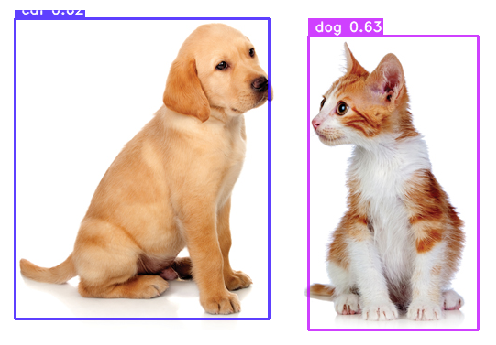

In [17]:
img = cv2.imread("/content/catanddog.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
outputs = model.predict(img)
outputs.show()